# Movie Recommender System

### Data Dictionary:

 * 100,000 ratings (0.5-5.0) from 671 users on  9066 movies.

 * Each user has rated at least 20 movies.

**Movies:** 

**1 - movieId** : Unique id for each movie.

**2 - title** : Name of the movie.

**3 - genres** : list of genres of movie(Type-ex:Comedy)

**Ratings:**

**4 - userId** : Unique id for each user.

**5 - movieId** : Unique id for each movie.

**6 - ratings** : Values which are rated by the user for each movie (0.5-5.0)

# 1. Import Libraries <a id='import_lib'></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import mean_squared_error
import math
from wordcloud import WordCloud

%matplotlib inline
plt.rcParams['figure.figsize'] = (6, 4)
plt.style.use('ggplot')
%config InlineBackend.figure_formats = {'png', 'retina'}

# 2. Setting Options <a id='set_options'></a>

In [2]:
from warnings import filterwarnings
filterwarnings('ignore')
# return an output value upto 3 decimals
pd.options.display.float_format = '{:.3f}'.format

# 3. Read Data <a id='Read_Data'></a>

###  Movies <a id='mov'></a>

In [3]:
movies_df=pd.read_csv('movies.csv')
print(movies_df.shape)
movies_df.head(10)

(9742, 3)


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
5,6,Heat (1995),Action|Crime|Thriller
6,7,Sabrina (1995),Comedy|Romance
7,8,Tom and Huck (1995),Adventure|Children
8,9,Sudden Death (1995),Action
9,10,GoldenEye (1995),Action|Adventure|Thriller


In [4]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


In [5]:
ratings_df =pd.read_csv('ratings.csv')
print(ratings_df.shape)
ratings_df.head()

(100836, 4)


,userId,movieId,rating,timestamp
0,1,1,4.000,964982703
1,1,3,4.000,964981247
2,1,6,4.000,964982224
3,1,47,5.000,964983815
4,1,50,5.000,964982931


In [6]:
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


# 4. Exploratory Data Analysis <a id='data_preparation'></a>

## Preparing the Dataset <a id='Data_Preparing'></a>

In [7]:
genres_df = pd.DataFrame(movies_df.genres.str.split('|').tolist()).stack().unique()
genres_df = pd.DataFrame(genres_df, columns = ['genres'])
movies_df = movies_df.join(movies_df.genres.str.get_dummies())

#Using regex to find a year stored between parentheses
movies_df['year'] = movies_df.title.str.extract('(\(\d\d\d\d\))',expand=False)
#Removing the parentheses
movies_df['year'] = movies_df.year.str.extract('(\d\d\d\d)',expand=False)
#Removing the years from the 'title' column
#movies_df['title'] = movies_df.title.str.replace('(\(\d\d\d\d\))', '')
#Applying the strip function to get rid of any ending whitespace characters that may have appeared
#movies_df['title'] = movies_df['title'].apply(lambda x: x.strip())

#Every genre is separated by a | so we simply have to call the split function on |
movies_df['genres'] = movies_df.genres.str.replace('|',',')

movies_df.head()

,movieId,title,genres,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,...,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,year
0,1,Toy Story (1995),"Adventure,Animation,Children,Comedy,Fantasy",0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,1995
1,2,Jumanji (1995),"Adventure,Children,Fantasy",0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1995
2,3,Grumpier Old Men (1995),"Comedy,Romance",0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,1995
3,4,Waiting to Exhale (1995),"Comedy,Drama,Romance",0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,1995
4,5,Father of the Bride Part II (1995),Comedy,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1995


###  Merging dataframes <a id='merging'></a>

In [8]:
data = pd.merge(movies_df, ratings_df, on="movieId")
##Removing unwanted feature (timestamp) from ratings dataset
data.drop('timestamp',axis=1,inplace=True)
data.head()

,movieId,title,genres,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,...,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,year,userId,rating
0,1,Toy Story (1995),"Adventure,Animation,Children,Comedy,Fantasy",0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,1995,1,4.000
1,1,Toy Story (1995),"Adventure,Animation,Children,Comedy,Fantasy",0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,1995,5,4.000
2,1,Toy Story (1995),"Adventure,Animation,Children,Comedy,Fantasy",0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,1995,7,4.500
3,1,Toy Story (1995),"Adventure,Animation,Children,Comedy,Fantasy",0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,1995,15,2.500
4,1,Toy Story (1995),"Adventure,Animation,Children,Comedy,Fantasy",0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,1995,17,4.500


###  Data Info <a id='info'></a>

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100836 entries, 0 to 100835
Data columns (total 26 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   movieId             100836 non-null  int64  
 1   title               100836 non-null  object 
 2   genres              100836 non-null  object 
 3   (no genres listed)  100836 non-null  int64  
 4   Action              100836 non-null  int64  
 5   Adventure           100836 non-null  int64  
 6   Animation           100836 non-null  int64  
 7   Children            100836 non-null  int64  
 8   Comedy              100836 non-null  int64  
 9   Crime               100836 non-null  int64  
 10  Documentary         100836 non-null  int64  
 11  Drama               100836 non-null  int64  
 12  Fantasy             100836 non-null  int64  
 13  Film-Noir           100836 non-null  int64  
 14  Horror              100836 non-null  int64  
 15  IMAX                100836 non-nul

### Data Dimensions <a id='Data_Shape'></a>

In [10]:
data.shape

(100836, 26)

###  Data Types <a id='Data_Types'></a>

In [11]:
data.dtypes

movieId                 int64
title                  object
genres                 object
(no genres listed)      int64
Action                  int64
Adventure               int64
Animation               int64
Children                int64
Comedy                  int64
Crime                   int64
Documentary             int64
Drama                   int64
Fantasy                 int64
Film-Noir               int64
Horror                  int64
IMAX                    int64
Musical                 int64
Mystery                 int64
Romance                 int64
Sci-Fi                  int64
Thriller                int64
War                     int64
Western                 int64
year                   object
userId                  int64
rating                float64
dtype: object

In this dataset I have **1 float , 3 object and 22 int columns**

### Check missing values <a id='Missing_Values'></a>

In [12]:
missing_value = pd.DataFrame({
    'Missing Value': data.isnull().sum(),
    'Percentage': (data.isnull().sum() / len(data))*100
})

In [13]:
missing_value.sort_values(by='Percentage', ascending=False)

,Missing Value,Percentage
year,18,0.018
movieId,0,0.000
title,0,0.000
userId,0,0.000
Western,0,0.000
War,0,0.000
Thriller,0,0.000
Sci-Fi,0,0.000
Romance,0,0.000
Mystery,0,0.000


There is only one column with 18 missing data values

**Handling Missing Values**

Since,there are very few missing values present in the data, I am dropping the null values.

In [14]:
data.dropna(inplace=True)

When dropping the null values, the index range is 1 off and needs to be reset

In [15]:
data['year']=data['year'].astype('int64')

In [16]:
data.reset_index(inplace=True,drop=True)

In [17]:
data.shape

(100818, 26)

Now, There are no missing values in the dataset

##  Understanding the Dataset <a id='Data_Understanding'></a>

###  Summary Statistics <a id='Summary_Statistics'></a>

**Numeric Variables**

In [18]:
data.describe(include=np.number)

,movieId,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,...,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,year,userId,rating
count,100818.000,100818.000,100818.000,100818.000,100818.000,100818.000,100818.000,100818.000,100818.000,100818.000,...,100818.000,100818.000,100818.000,100818.000,100818.000,100818.000,100818.000,100818.000,100818.000,100818.000
mean,19412.911,0.000,0.304,0.240,0.069,0.091,0.387,0.165,0.012,0.416,...,0.041,0.076,0.180,0.171,0.262,0.048,0.019,1994.445,326.129,3.502
std,35490.816,0.019,0.460,0.427,0.254,0.288,0.487,0.372,0.109,0.493,...,0.198,0.265,0.384,0.376,0.440,0.214,0.137,14.361,182.620,1.042
min,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1902.000,1.000,0.500
25%,1199.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1990.000,177.000,3.000
50%,2991.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1997.000,325.000,3.500
75%,8044.000,0.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000,1.000,...,0.000,0.000,0.000,0.000,1.000,0.000,0.000,2003.000,477.000,4.000
max,193609.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,...,1.000,1.000,1.000,1.000,1.000,1.000,1.000,2018.000,610.000,5.000


From the above table , I infer:

    1.  There are 100818 values present in the dataset
    
    2.  The maximum value for rating is 5 and where as the minimum value is 0.5 and the average rating is 3.5

**Categorical Variables**

In [19]:
data.describe(include = object)

,title,genres
count,100818,100818
unique,9706,951
top,Forrest Gump (1994),Comedy
freq,329,7196


From the above table, I infer:

    1. The movie Forest Grump has been rated the most among all the movies with frequency of 329.
    
    2. Out of all geres the Drama genre movie has been watched and rated most with the frequency 7196.

### 4 Correlation <a id='correlation'></a>

In [20]:
corr_matrix=data.corr()
corr_matrix

,movieId,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,...,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,year,userId,rating
movieId,1.000,0.070,0.072,0.047,0.075,-0.014,-0.036,-0.016,0.057,-0.020,...,-0.053,-0.002,-0.074,0.077,-0.011,-0.027,-0.017,0.512,0.007,-0.004
(no genres listed),0.070,1.000,-0.013,-0.011,-0.005,-0.006,-0.015,-0.009,-0.002,-0.016,...,-0.004,-0.005,-0.009,-0.009,-0.011,-0.004,-0.003,0.017,0.002,-0.002
Action,0.072,-0.013,1.000,0.327,-0.096,-0.146,-0.246,0.099,-0.068,-0.236,...,-0.121,-0.054,-0.188,0.320,0.260,0.068,0.036,0.117,-0.007,-0.034
Adventure,0.047,-0.011,0.327,1.000,0.224,0.234,-0.080,-0.180,-0.059,-0.255,...,0.012,-0.093,-0.148,0.236,-0.050,-0.051,0.030,0.047,-0.012,0.004
Animation,0.075,-0.005,-0.096,0.224,1.000,0.637,0.090,-0.090,-0.028,-0.135,...,0.320,-0.053,-0.011,-0.035,-0.153,-0.053,-0.030,0.016,-0.012,0.034
Children,-0.014,-0.006,-0.146,0.234,0.637,1.000,0.117,-0.119,-0.034,-0.146,...,0.313,-0.062,-0.043,-0.073,-0.187,-0.068,-0.033,-0.056,-0.018,-0.027
Comedy,-0.036,-0.015,-0.246,-0.080,0.090,0.117,1.000,-0.090,-0.055,-0.270,...,0.055,-0.170,0.197,-0.198,-0.343,-0.082,-0.029,0.038,-0.008,-0.089
Crime,-0.016,-0.009,0.099,-0.180,-0.090,-0.119,-0.090,1.000,-0.048,0.081,...,-0.083,0.132,-0.160,-0.145,0.279,-0.079,-0.047,0.033,-0.015,0.067
Documentary,0.057,-0.002,-0.068,-0.059,-0.028,-0.034,-0.055,-0.048,1.000,-0.074,...,-0.007,-0.030,-0.051,-0.050,-0.066,-0.009,-0.015,0.051,0.009,0.031
Drama,-0.020,-0.016,-0.236,-0.255,-0.135,-0.146,-0.270,0.081,-0.074,1.000,...,-0.056,0.018,0.110,-0.194,-0.040,0.186,-0.009,-0.020,0.003,0.125


Visualizing the correlation matrix with heatmap

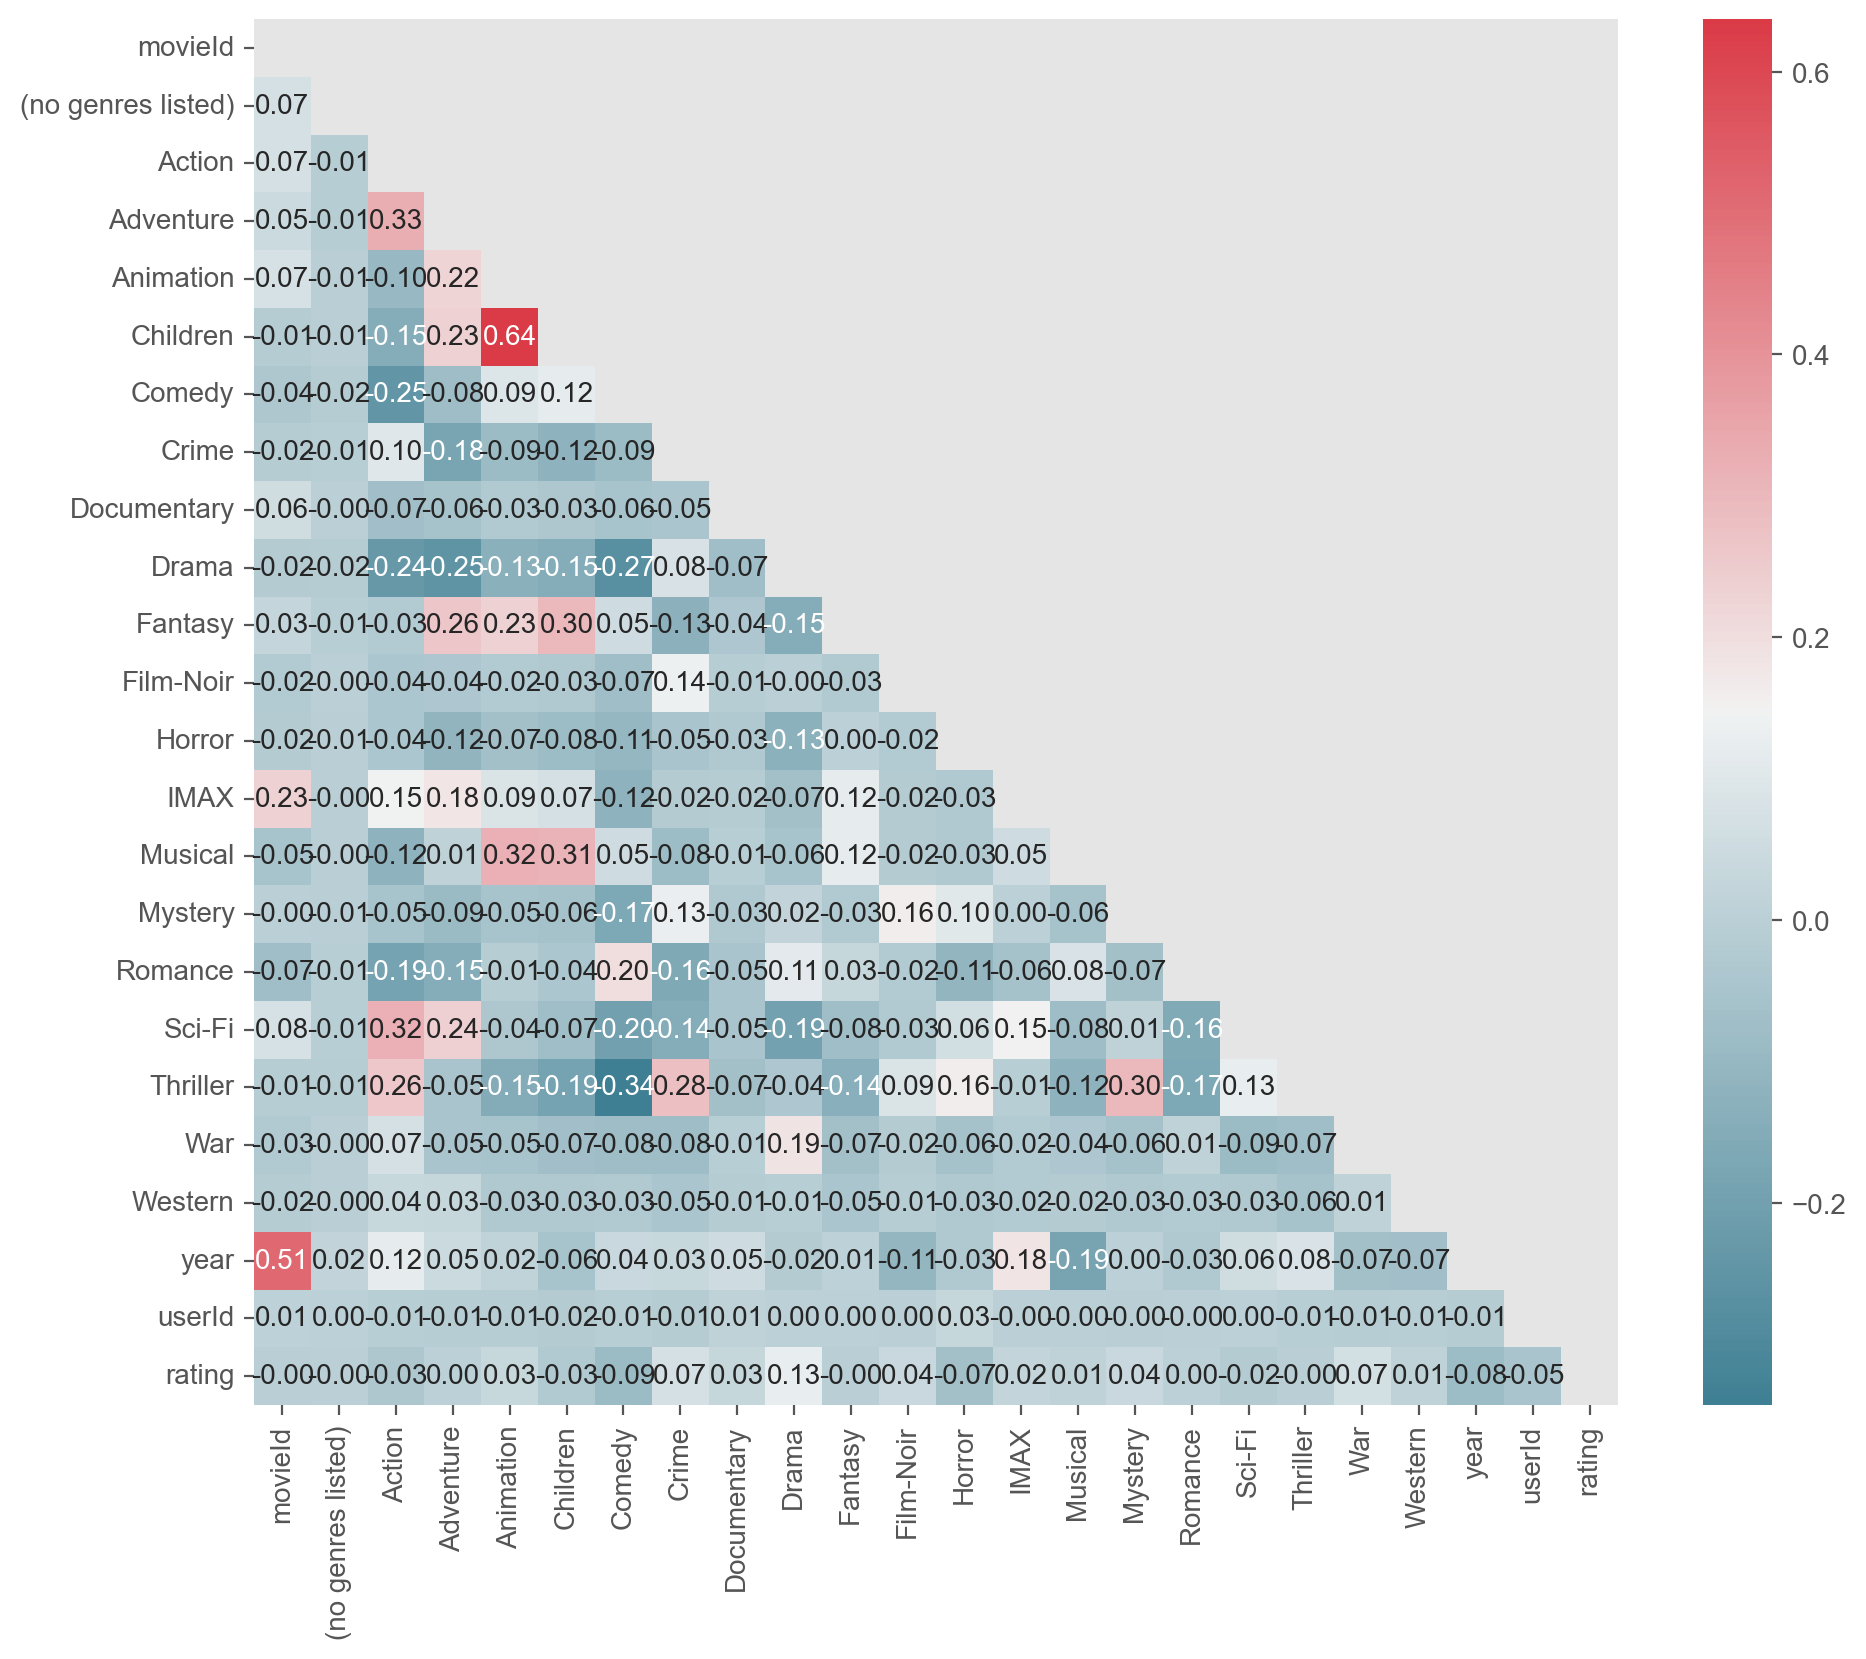

In [21]:
plt.figure(figsize=(11,9))
dropSelf = np.zeros_like(corr_matrix)
dropSelf[np.triu_indices_from(dropSelf)] = True

sns.heatmap(corr_matrix, cmap=sns.diverging_palette(220, 10, as_cmap=True), annot=True, fmt=".2f", mask=dropSelf)

sns.set(font_scale=1.5)

**Inferences:**
1. Animation and Children are bit highly correlated in the data (0.64)
    
2. Action and Adventure,Fantasy and children,Scifi and Action are bit moderately correlated.

### 4.2.3 Analyse Features <a id='analyze_fea'></a>

#### Average User Ratings

In [22]:
user_ratings =data[['userId','rating']].groupby('userId').mean()

Text(0, 0.5, 'Frequency')

<Figure size 800x800 with 0 Axes>

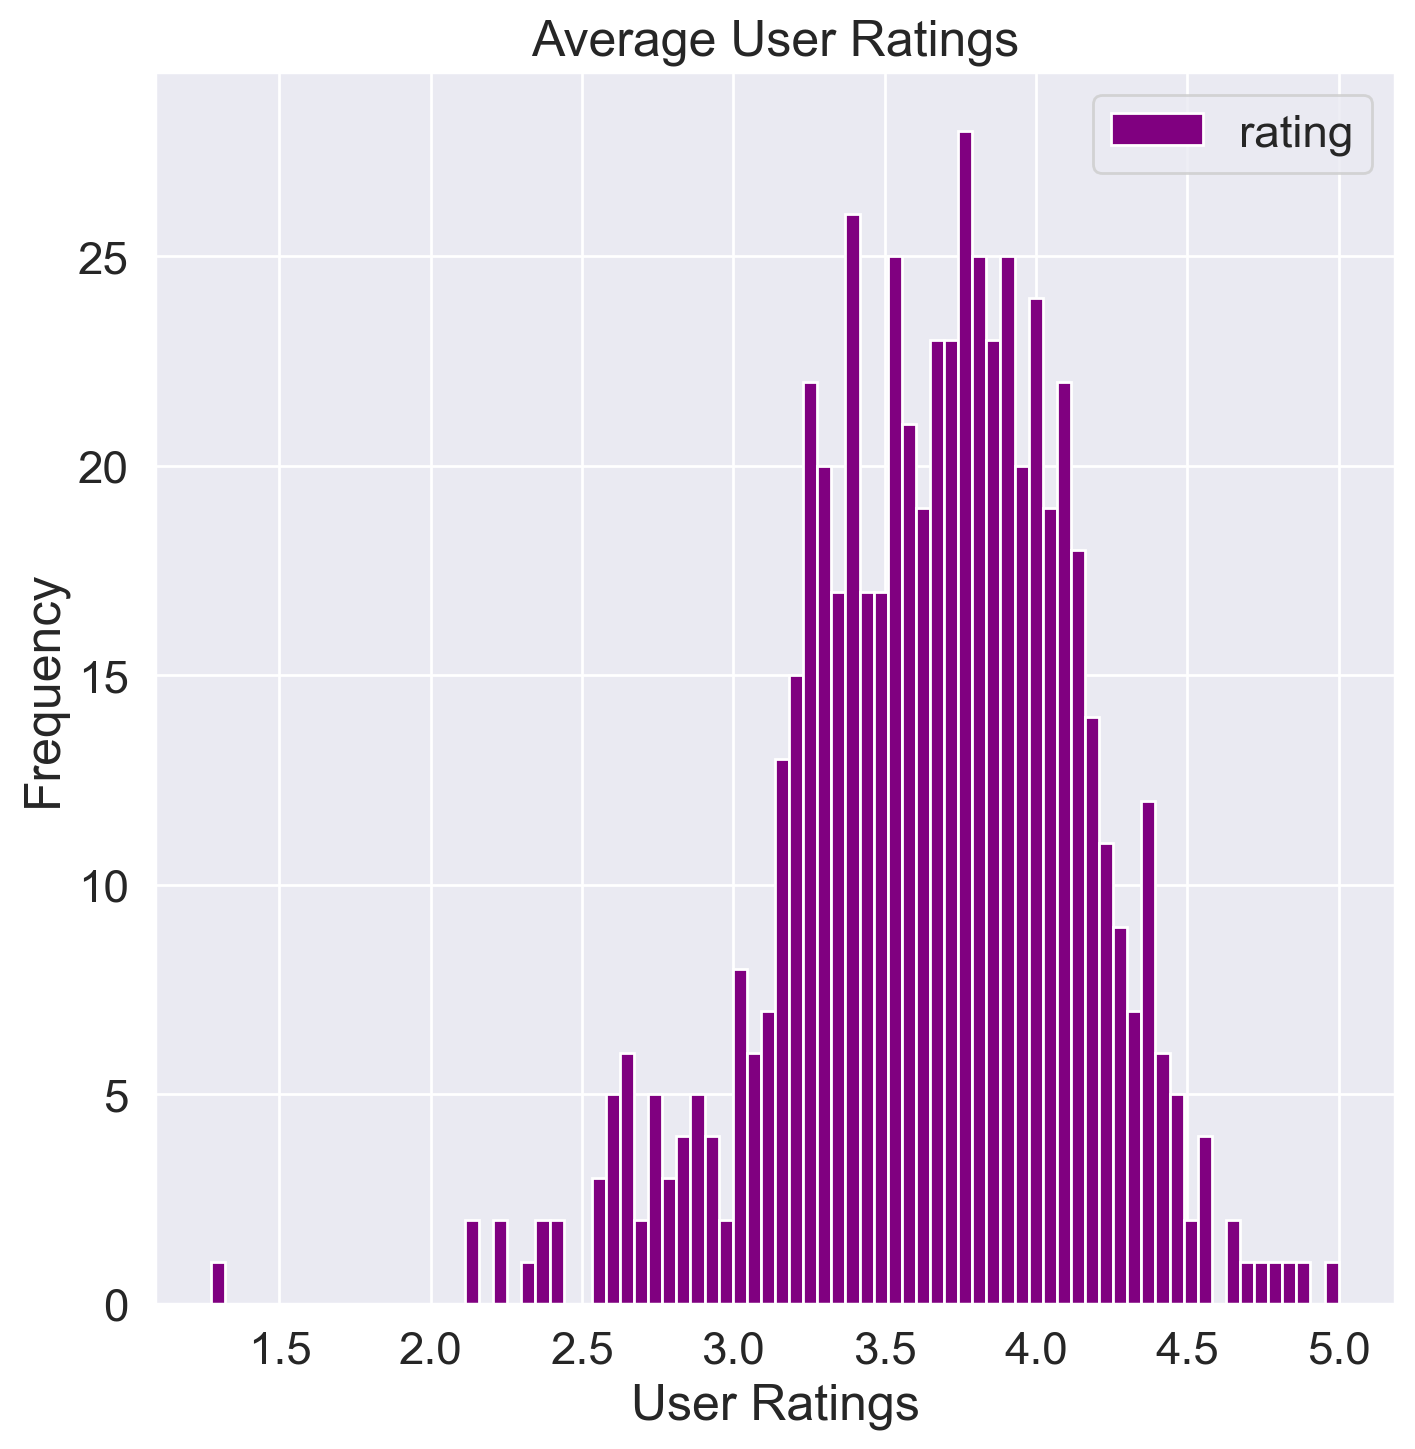

In [23]:
fig = plt.figure(figsize = (8,8))
user_ratings.plot(kind = 'hist', bins = 80, figsize = (8,8), color = 'purple')
plt.plot()
plt.xlabel('User Ratings')
plt.title('Average User Ratings')
plt.ylabel('Frequency')

Looking at the plots above, there is right-skewed distribution for the average movie ratings per genre. The central means of tendency happen between ratings 3 and 4. 

#### No.of movies released in each year.

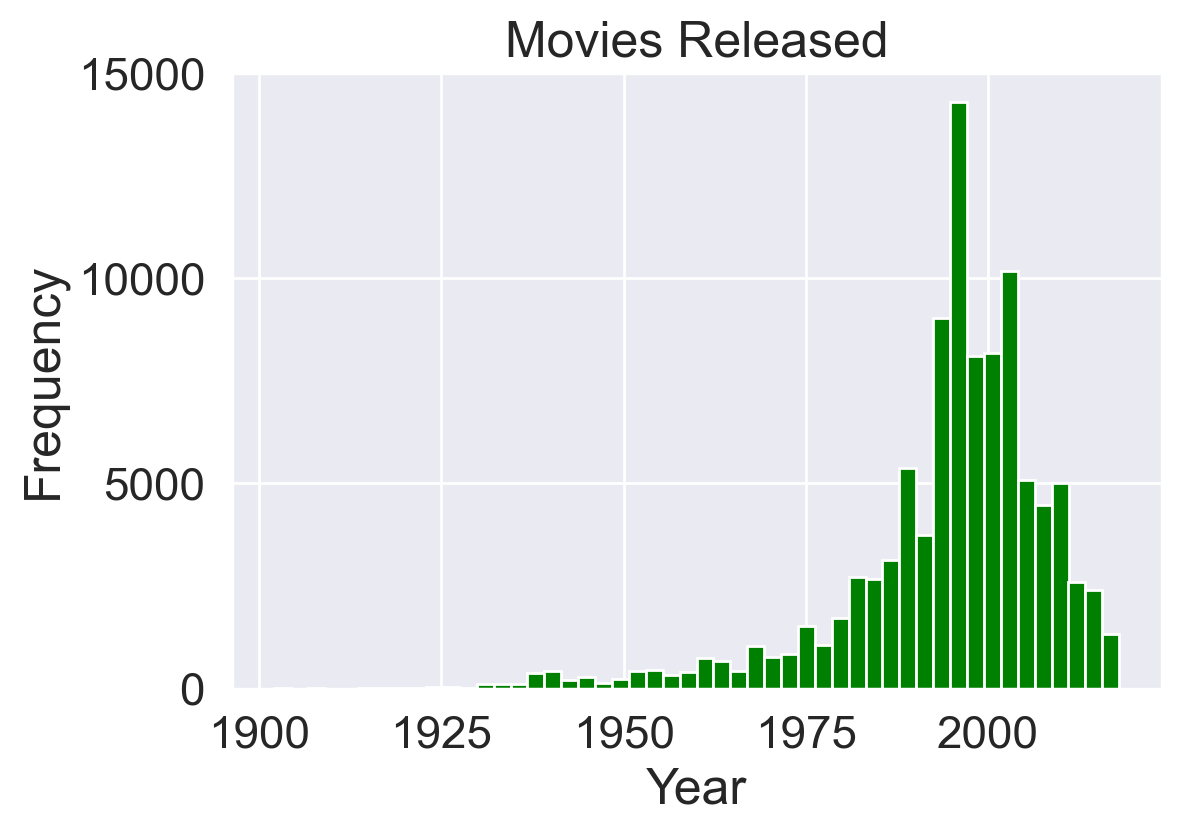

In [24]:
plt.hist(data['year'], bins=50, color = 'green')
plt.xlabel('Year')
plt.title('Movies Released')
plt.ylabel('Frequency')
plt.show()

From this plot, we can see most of the movies released were around 2000

#### Top 10 users who have rated most of the movies

In [25]:
ratings_df.drop('timestamp',axis=1,inplace=True)
##Calculating the average rating for each user id
ratings_grouped_by_users = ratings_df.groupby('userId').agg([np.size, np.mean])
ratings_grouped_by_users = ratings_grouped_by_users.drop('movieId', axis = 1)
ratings_grouped_by_users.head(10)

rating      
         size  mean
userId             
1         232 4.366
2          29 3.948
3          39 2.436
4         216 3.556
5          44 3.636
6         314 3.494
7         152 3.230
8          47 3.574
9          46 3.261
10        140 3.279

<AxesSubplot:xlabel='userId'>

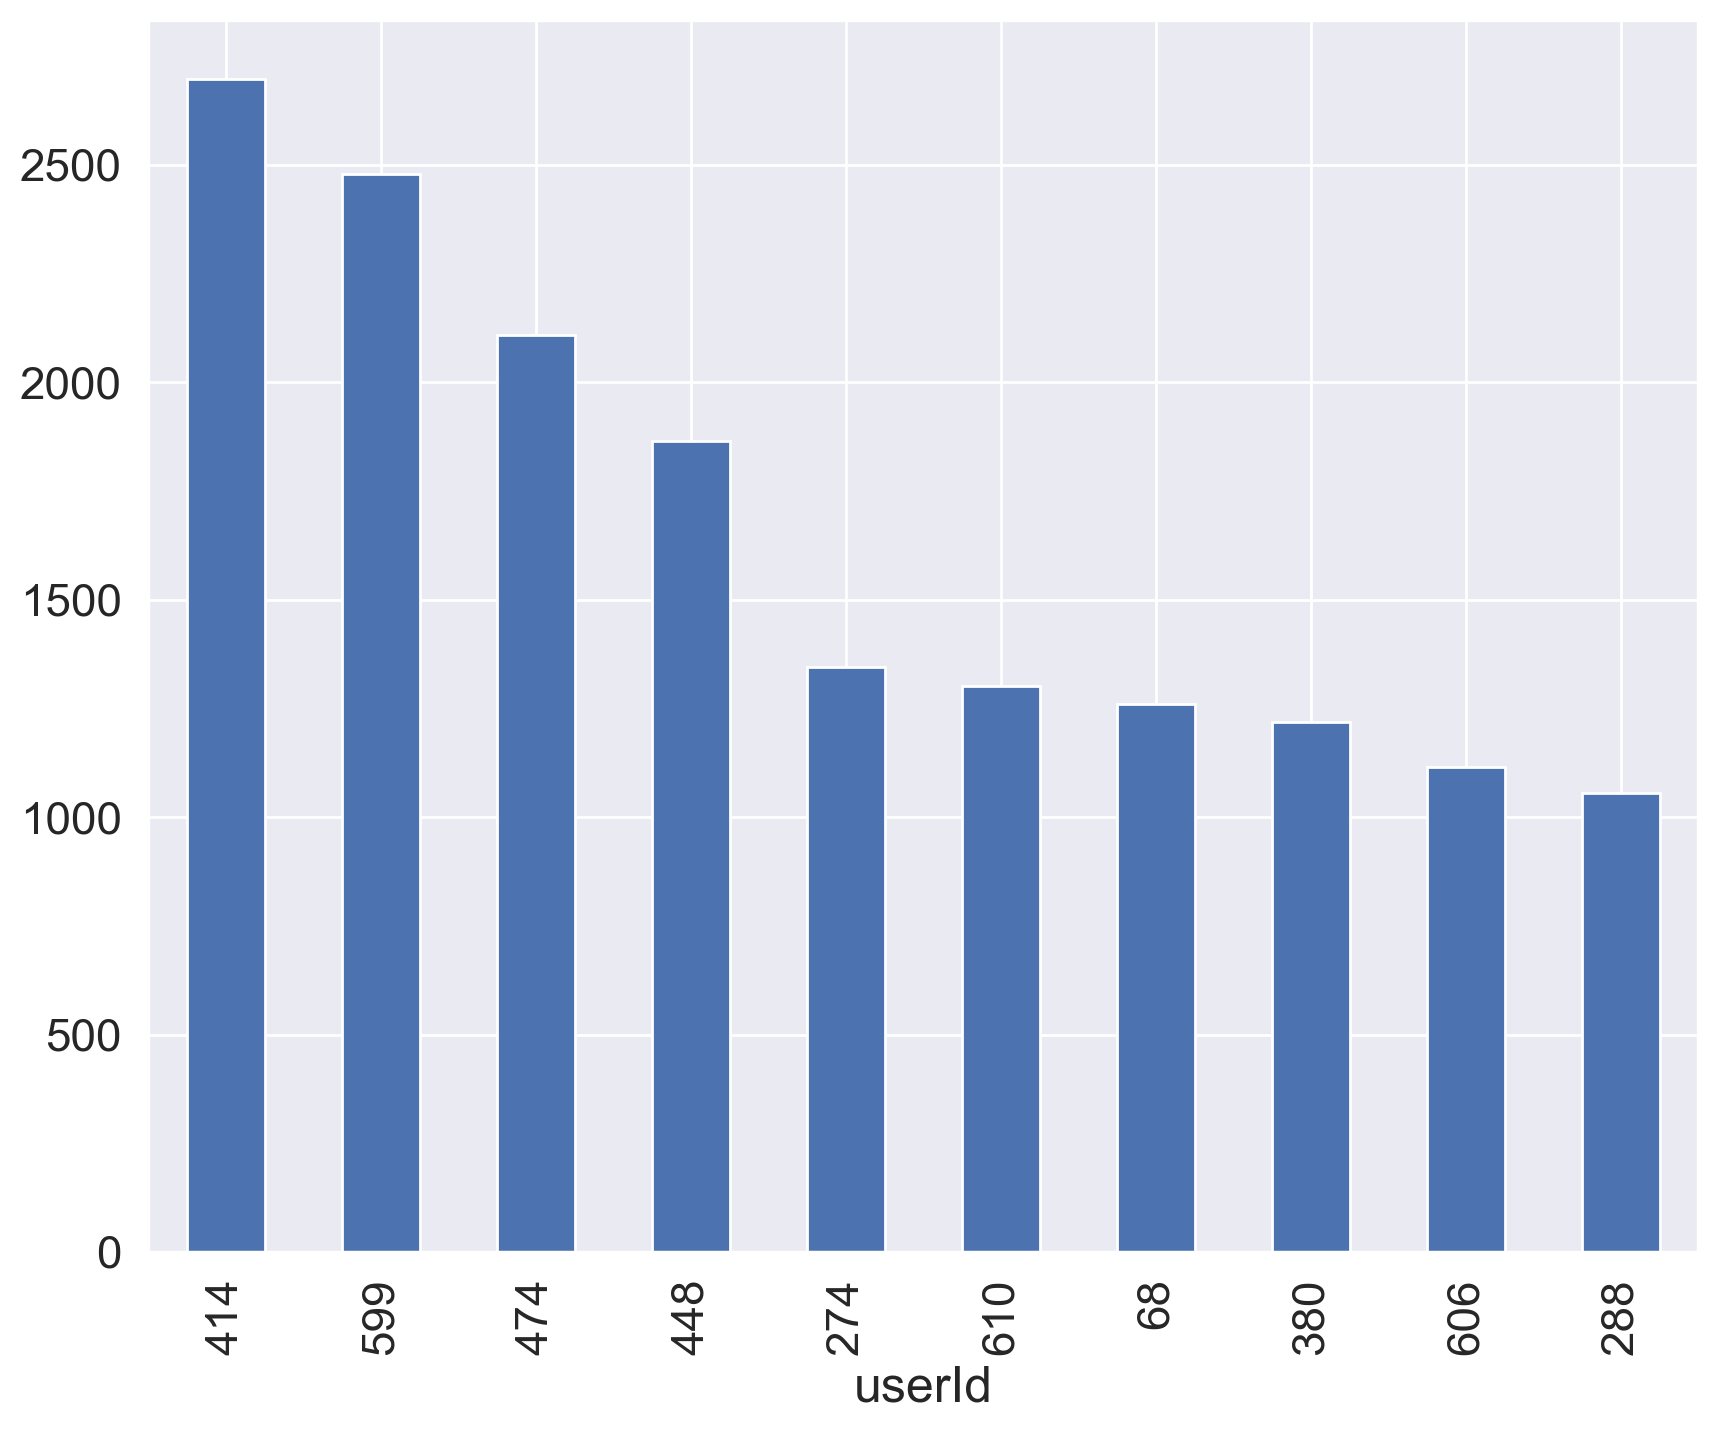

In [26]:
ratings_grouped_by_users['rating']['size'].sort_values(ascending=False).head(10).plot(kind='bar',figsize=(10,8))

The above plot shows the top 10 users who have rated most of the movies.  User 414 have rated most of the movies.

#### Movies with high average rating

In [27]:
##Average rating for each movie
ratings_grouped_by_movies = ratings_df.groupby('movieId').agg([np.mean], np.size)
print(ratings_grouped_by_movies.shape)
ratings_grouped_by_movies = ratings_grouped_by_movies.drop('userId', axis=1)
ratings_grouped_by_movies.head(25)

(9724, 2)


,rating
,mean
movieId,
1,3.921
2,3.432
3,3.260
4,2.357
5,3.071
6,3.946
7,3.185
8,2.875


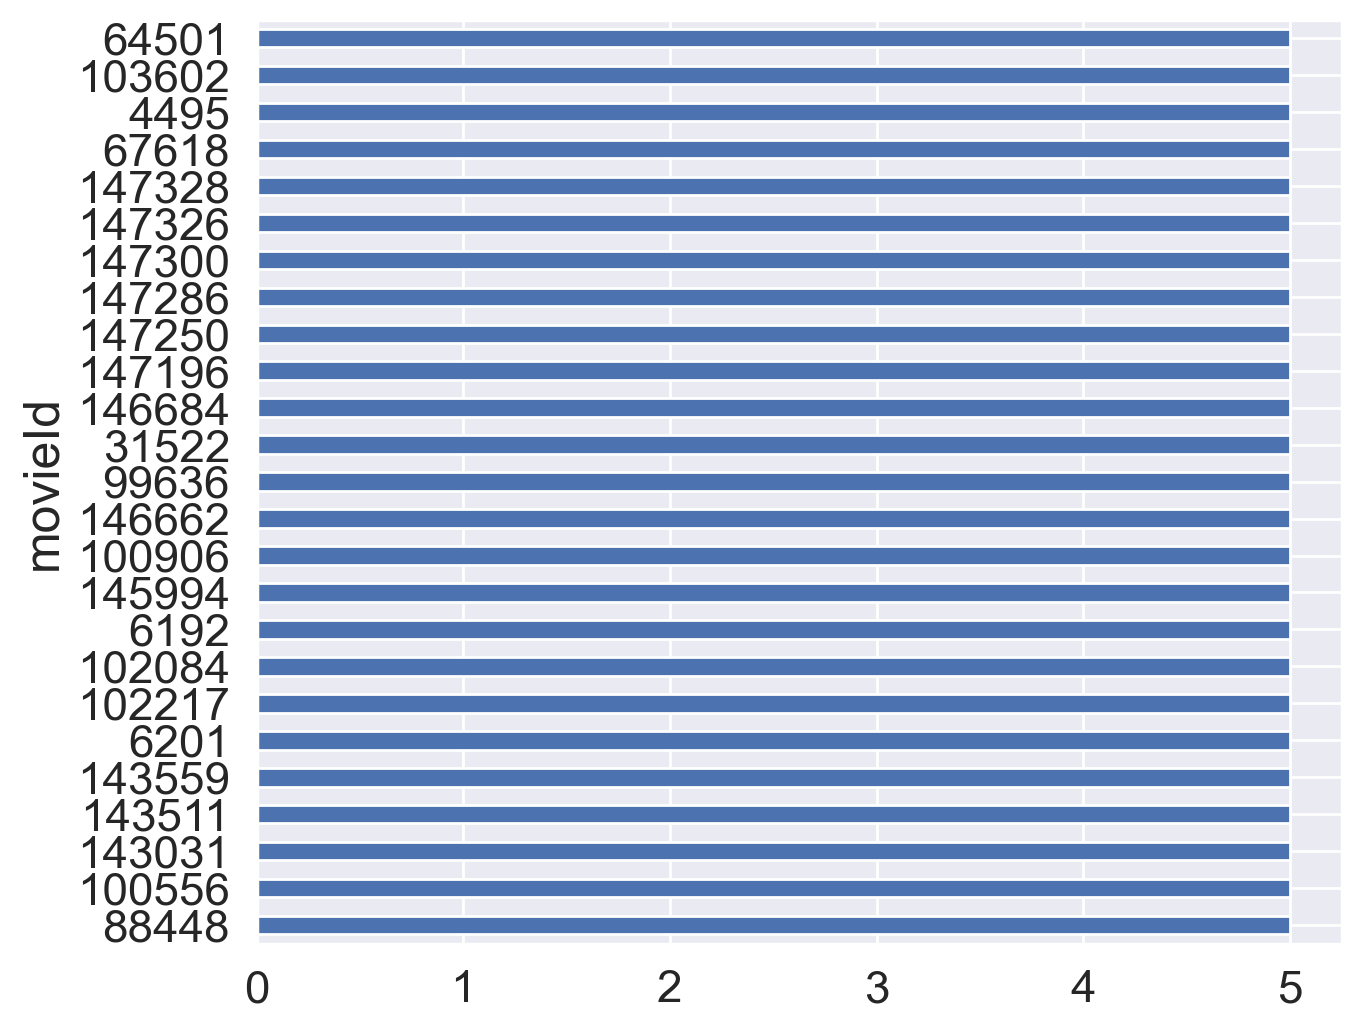

In [28]:
#top20 highest rated movies
ratings_grouped_by_movies['rating']['mean'].sort_values(ascending=False).head(25).plot(kind='barh', figsize=(7,6));

The above plot shows top 20 movies with high average rating.

#### Movies with low average rating

In [29]:
### movies having the average rating less than 1.5
low_rated_movies_filter = ratings_grouped_by_movies['rating']['mean']< 1.5
low_rated_movies = ratings_grouped_by_movies[low_rated_movies_filter]
low_rated_movies.head()

,rating
,mean
movieId,
178,1.000
312,1.444
449,1.000
470,1.000
476,1.000


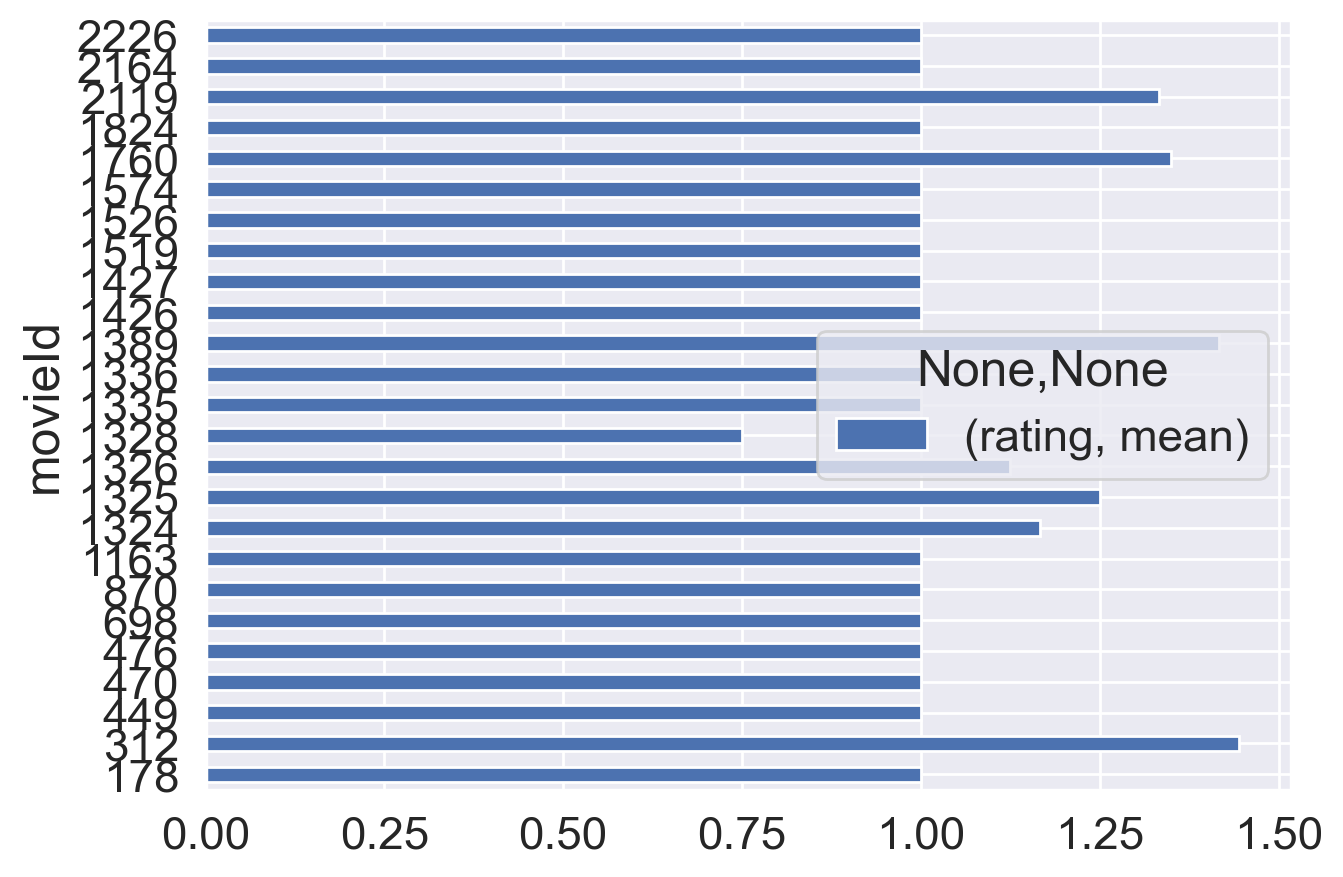

In [30]:
low_rated_movies.head(25).plot(kind='barh', figsize=(7,5));

The above plot shows bottom 20 low rated movies.

#### Average Movie Ratings by Genre

In [31]:
density_df = data[['movieId', 'rating']].groupby('movieId').mean()

In [32]:
density_df.head()

,rating
movieId,
1,3.921
2,3.432
3,3.260
4,2.357
5,3.071


In [33]:
genres_df.count()

genres    20
dtype: int64

In [34]:
data_copy=data.copy()
data_copy.drop('genres', inplace = True, axis=1)

In [35]:
data_copy.head()

,movieId,title,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,...,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,year,userId,rating
0,1,Toy Story (1995),0,0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,1995,1,4.000
1,1,Toy Story (1995),0,0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,1995,5,4.000
2,1,Toy Story (1995),0,0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,1995,7,4.500
3,1,Toy Story (1995),0,0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,1995,15,2.500
4,1,Toy Story (1995),0,0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,1995,17,4.500


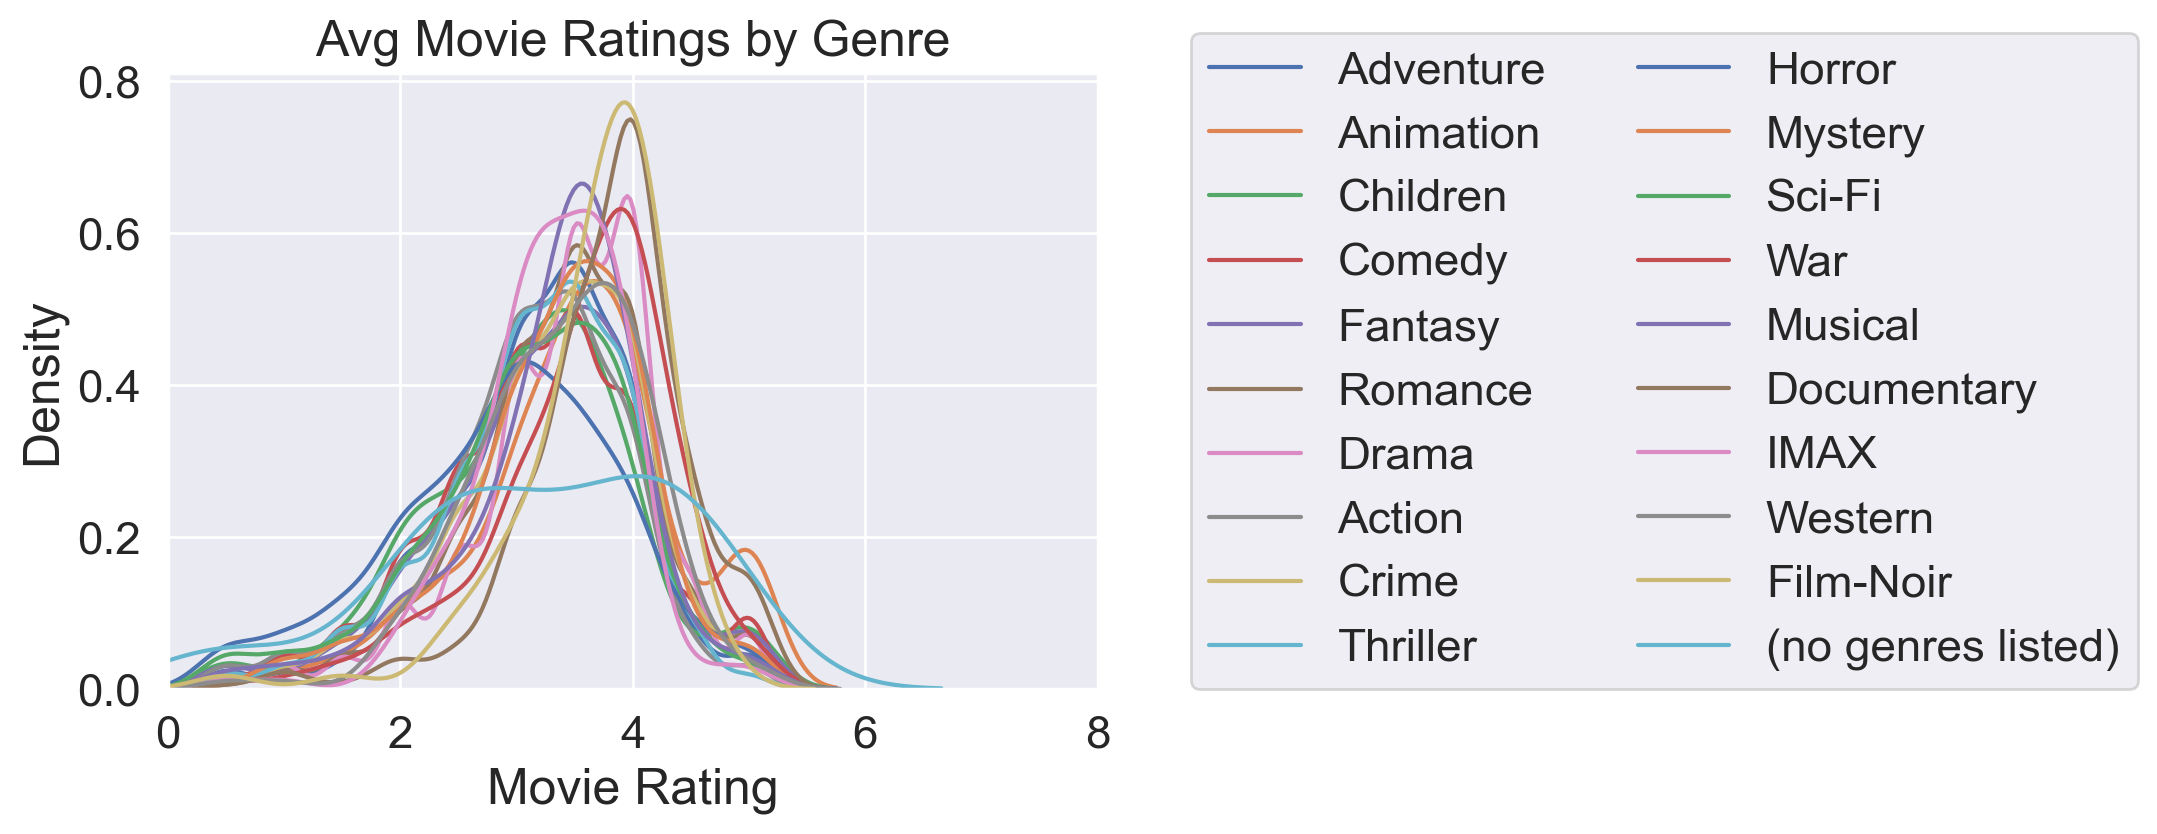

<Figure size 2000x2000 with 0 Axes>

In [36]:
for genres in genres_df.genres:
    density_df = data_copy[data_copy[genres] == True]
    density_df = data_copy[data_copy.set_index('movieId').index.isin(density_df.set_index('movieId').index)]
    density_df = density_df[['movieId', 'rating']].groupby('movieId').mean()
    sns.distplot(density_df.rating, hist = False, kde = True, label = genres)
plt.legend(loc = (1.10,0), ncol = 2)
plt.xlim(0,8)
plt.xlabel('Movie Rating')
plt.ylabel('Density')
plt.title('Avg Movie Ratings by Genre')
plt.figure(figsize=(20,20))
plt.show()

Using a pdf distribution plot in order to get the distribution of the average movie rating per genre,it is clear that people rarely rate movies lower than 3 stars, which contributes to a right-skewed distribution. The Thriller genre is bit normally distributed.

## 5. Dimensionality Reduction <a id='dim_red'></a>

### PCA (Principal Component Analysis) <a id='pca'></a>

In [37]:
data.head()

,movieId,title,genres,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,...,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,year,userId,rating
0,1,Toy Story (1995),"Adventure,Animation,Children,Comedy,Fantasy",0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,1995,1,4.000
1,1,Toy Story (1995),"Adventure,Animation,Children,Comedy,Fantasy",0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,1995,5,4.000
2,1,Toy Story (1995),"Adventure,Animation,Children,Comedy,Fantasy",0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,1995,7,4.500
3,1,Toy Story (1995),"Adventure,Animation,Children,Comedy,Fantasy",0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,1995,15,2.500
4,1,Toy Story (1995),"Adventure,Animation,Children,Comedy,Fantasy",0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,1995,17,4.500


In [38]:
user_movie =pd.crosstab(data['userId'],data['title'])

In [39]:
user_movie.head(10)

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [40]:
user_movie.shape

(610, 9706)

In [41]:
pca = PCA(n_components=20)#we use 20 because there are 20 features we are interested in
pca.fit(user_movie)
pca_samples = pca.transform(user_movie)

In [42]:
ps= pd.DataFrame(pca_samples)

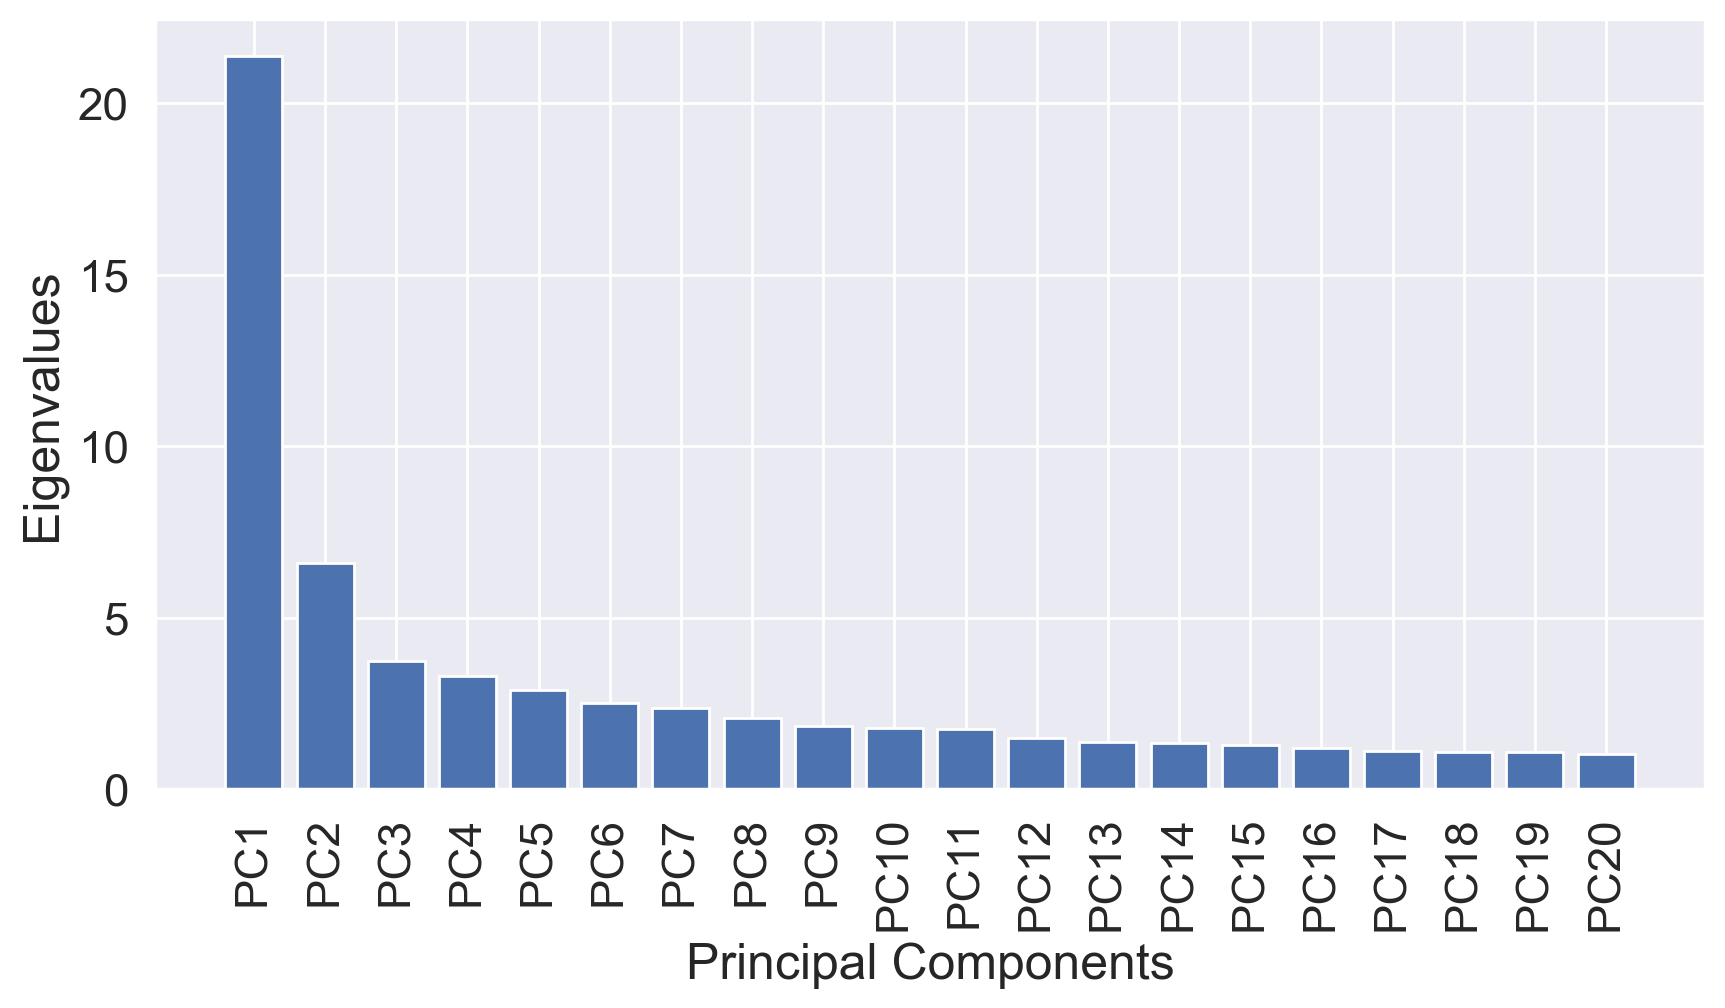

In [43]:
pcs = ['PC'+str(i) for i in range(1,21)]
pca.explained_variance_
plt.figure(figsize=(10, 5))
plt.bar(pcs, pca.explained_variance_)
plt.ylabel('Eigenvalues')
plt.xlabel('Principal Components')
plt.xticks(rotation=90)
plt.show()

From the plot,I can see first 2-3 principal components holds most the variance. I will examine the variance explained by all 20 components and choose clusters based on this. 

In [44]:
pca = PCA(n_components=20)
pca.fit(user_movie)
pca_samples = pca.transform(user_movie)

Below is the variation that holds by each component.

In [45]:
np.cumsum(pca.explained_variance_ratio_)


array([0.14286092, 0.18694702, 0.21195036, 0.23408728, 0.2533638 ,
       0.27010234, 0.28593505, 0.29975119, 0.31211175, 0.32416539,
       0.33589591, 0.34597936, 0.35521878, 0.36433141, 0.37294398,
       0.38101774, 0.38852592, 0.39586654, 0.40309773, 0.40998046])

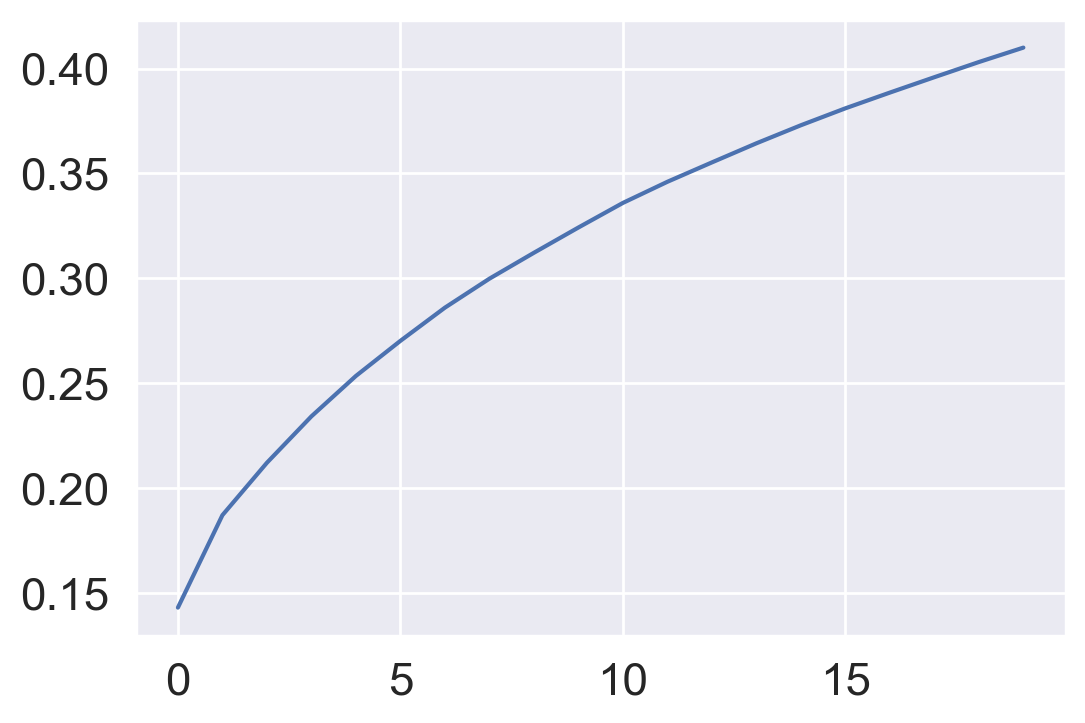

In [46]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.show()

In [47]:
ps = pd.DataFrame(pca_samples)
#the dataframe of pca samples
ps.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,2.592,3.113,0.358,-1.621,-2.769,-1.225,-0.253,0.303,-0.727,-0.042,-0.534,-1.200,-0.340,-0.851,0.210,-0.604,0.686,0.420,-0.228,0.760
1,-2.936,-1.164,0.345,1.271,-0.160,-0.202,-0.232,-0.020,0.146,-0.113,0.156,-0.460,0.031,-0.142,0.481,-0.153,-0.244,-0.222,0.206,0.061
2,-3.026,0.080,0.306,1.252,-0.117,-0.881,-0.549,0.052,-0.016,0.384,-0.093,0.097,0.255,0.112,0.308,-0.057,0.183,-0.099,0.335,0.302
3,0.725,2.612,2.998,-0.159,-0.070,-0.123,0.374,-0.177,0.794,-1.303,-1.788,1.159,-1.244,0.498,-1.463,-0.576,0.398,-0.815,-1.825,-0.415
4,-2.511,1.094,-1.553,-0.210,1.061,0.931,0.890,-0.058,0.205,0.281,-0.544,0.121,0.036,0.220,-0.194,0.103,-0.074,-0.180,0.134,-0.370


I will choose 3 clusters based on PCA. There is not a very clear cut drop off in variance. Since it is unclear beyond 2 I will choose 3.

In [48]:
makecluster = pd.DataFrame(ps[[0,1,2]])

In [49]:
print(makecluster)

         0       1      2
0    2.592   3.113  0.358
1   -2.936  -1.164  0.345
2   -3.026   0.080  0.306
3    0.725   2.612  2.998
4   -2.511   1.094 -1.553
..     ...     ...    ...
605 12.129   3.700  9.664
606  1.280   2.670 -0.195
607 15.816   3.542 -4.506
608 -2.846   0.675 -1.386
609 15.686 -12.728 -0.515

[610 rows x 3 columns]


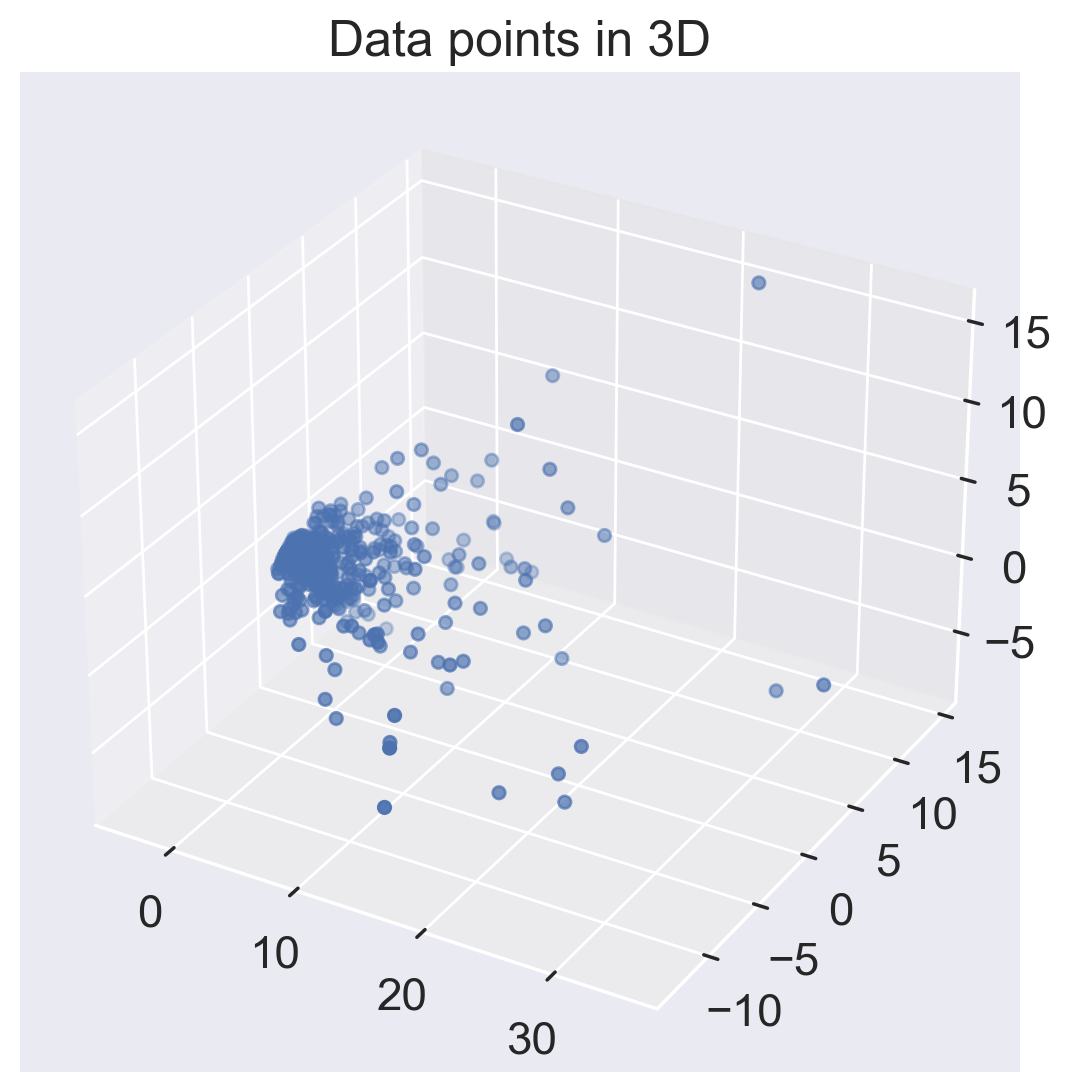

In [50]:
plt.rcParams['figure.figsize']=(10,5)
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(makecluster[0], makecluster[1], makecluster[2])
plt.title('Data points in 3D')
plt.show()

### 6. K-Means Clustering

Now we must find the number of k for clustering

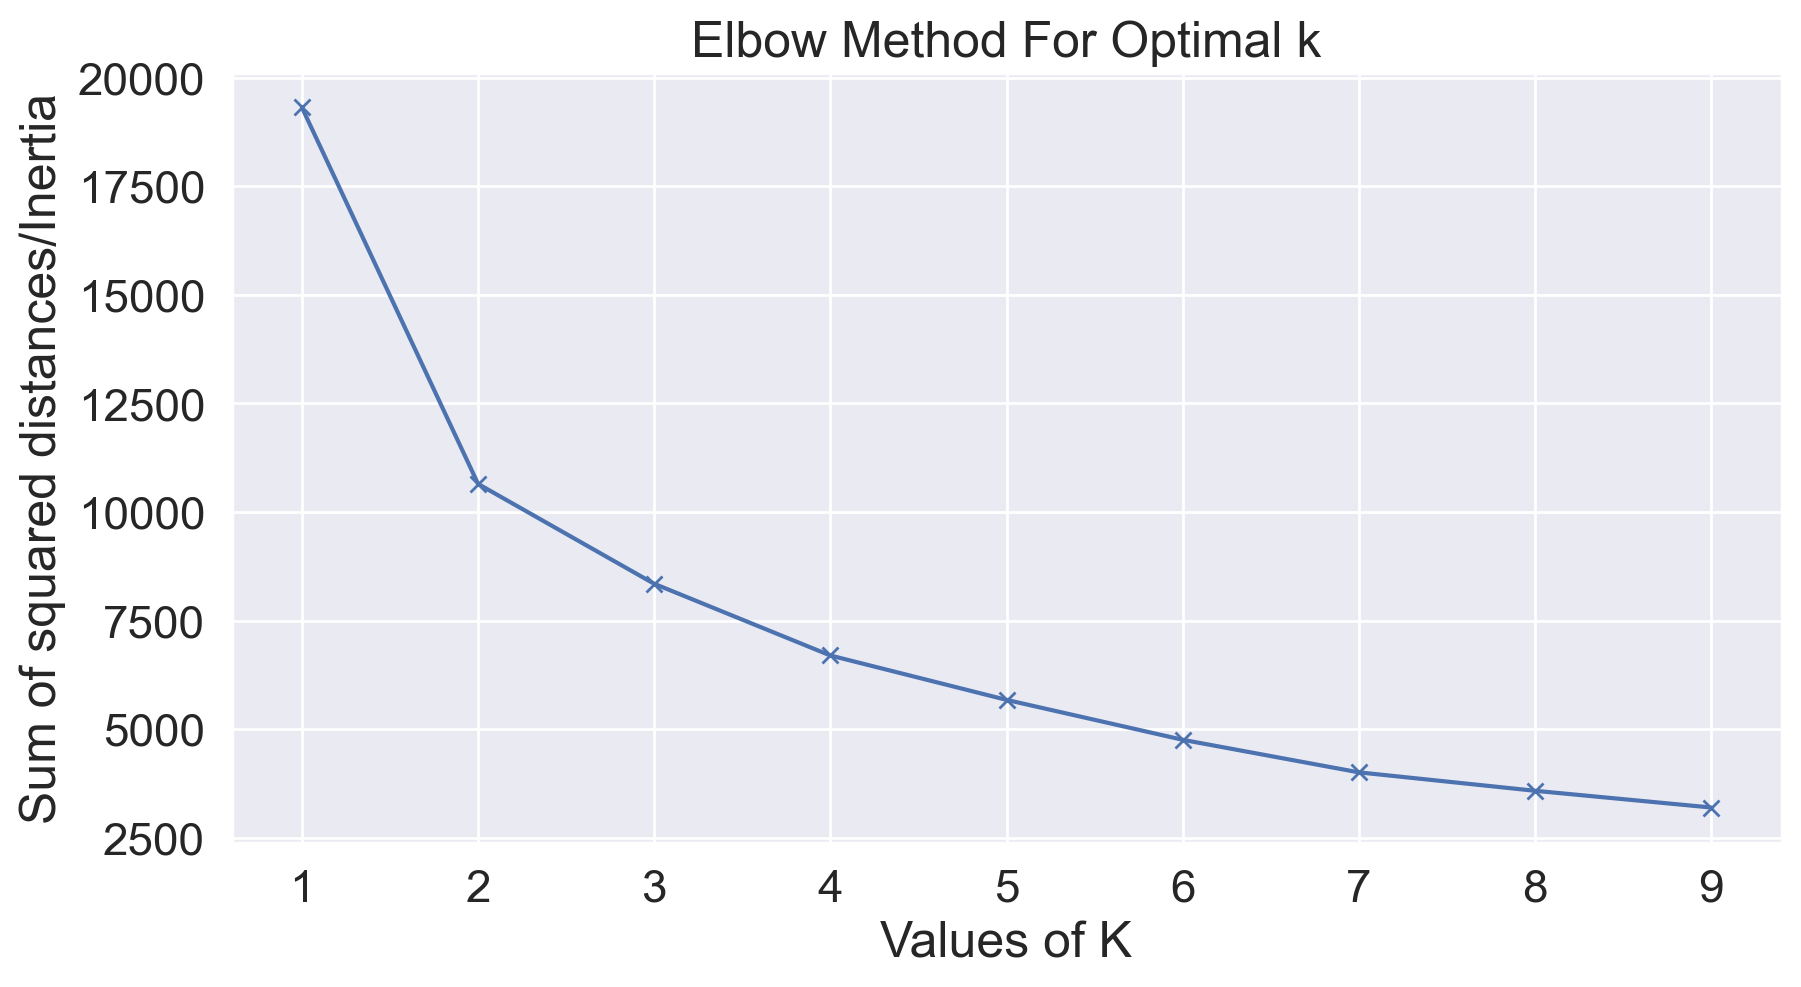

In [51]:
sum_of_squared_distances = []
K = range(1,10)
for num_clusters in K:
    kmeans= KMeans(n_clusters=num_clusters)
    kmeans.fit(makecluster)
    sum_of_squared_distances.append(kmeans.inertia_)

plt.plot(K,sum_of_squared_distances,'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Sum of squared distances/Inertia') 
plt.title('Elbow Method For Optimal k')
plt.show()

The plot looks like an arm, however there is not a clear "elbow." We do not have a clear cluster data, but looking at the graph the small elbow we do have howevers between 3 and 4 clusters. So we can chose a k of either 3 or 4 for the recommendation system. I will choose 4.

In [52]:
clusterer = KMeans(n_clusters=4, random_state=30).fit(makecluster)
centers = clusterer.cluster_centers_
c_preds = clusterer.predict(makecluster)

print(centers)

[[-1.89755686  0.2501709  -0.12463813]
 [17.72657907 -3.14707522 -3.48147395]
 [ 7.70735534  4.62848534  1.74170665]
 [ 3.34754035 -3.09570661  0.56530497]]


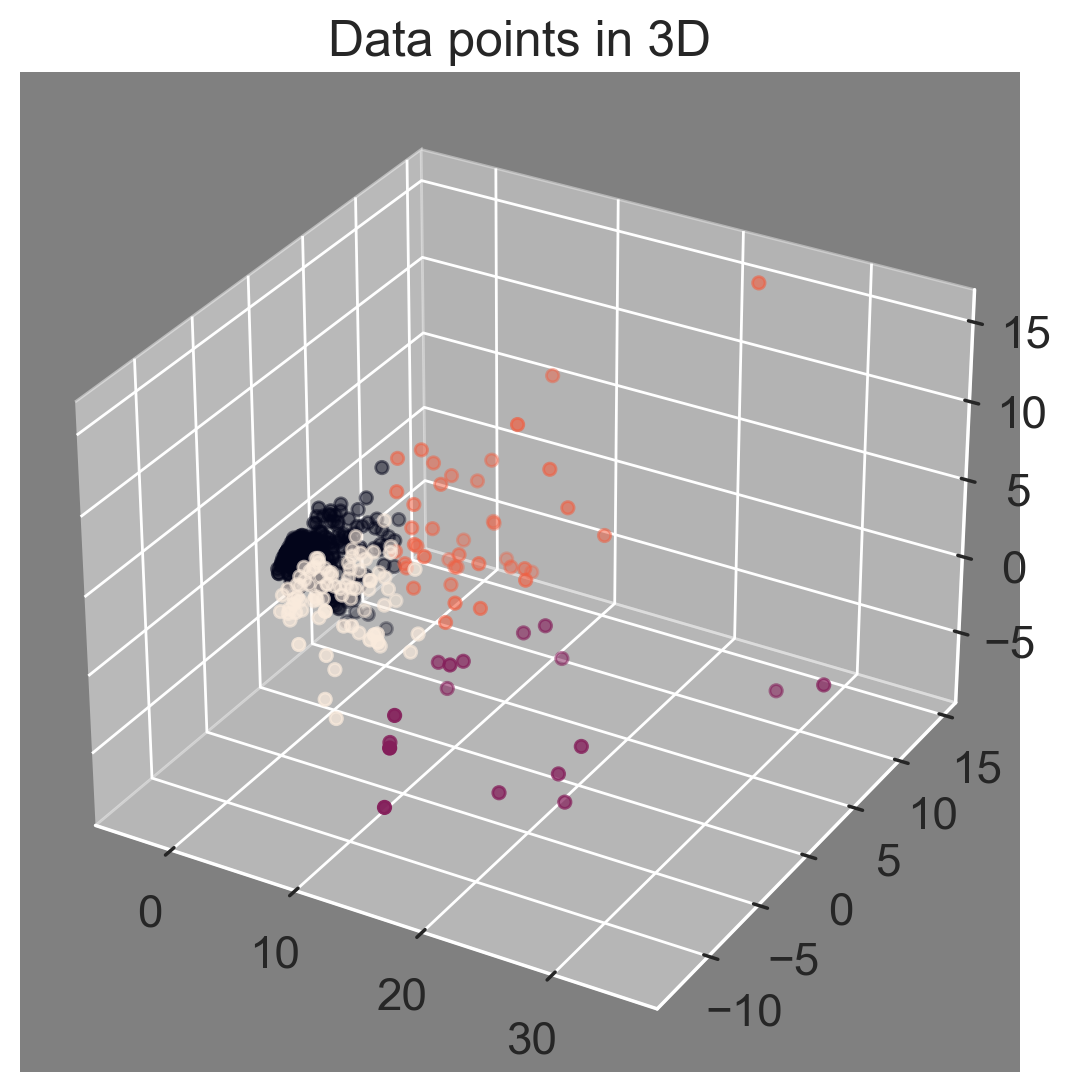

In [53]:
plt.rcParams['figure.figsize']=(10,5)
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(makecluster[0], makecluster[1], makecluster[2], c=c_preds)
ax.set(facecolor = "gray")
plt.title('Data points in 3D')
plt.show()

In [54]:
def cluster_plot(data, nclusters):
    plt.rcParams['figure.figsize']=(6,4)
    X = data.copy()
    km = KMeans(n_clusters=nclusters, init='random', n_init=10, max_iter=300, tol=1e-04, random_state=0)
    y_km = km.fit_predict(X)
    # Visualizing main scatter plot
    plt.figure(figsize=(8, 6))
    plt.scatter(X.iloc[:,0], X.iloc[:,1], c=km.labels_.astype(float))
    #Plotting the centroids
    plt.scatter(km.cluster_centers_[:, 0], km.cluster_centers_[:, 1], s=250, marker='o', c='green', label='centroids')
    plt.legend(scatterpoints=1)
    plt.grid()
    plt.show()

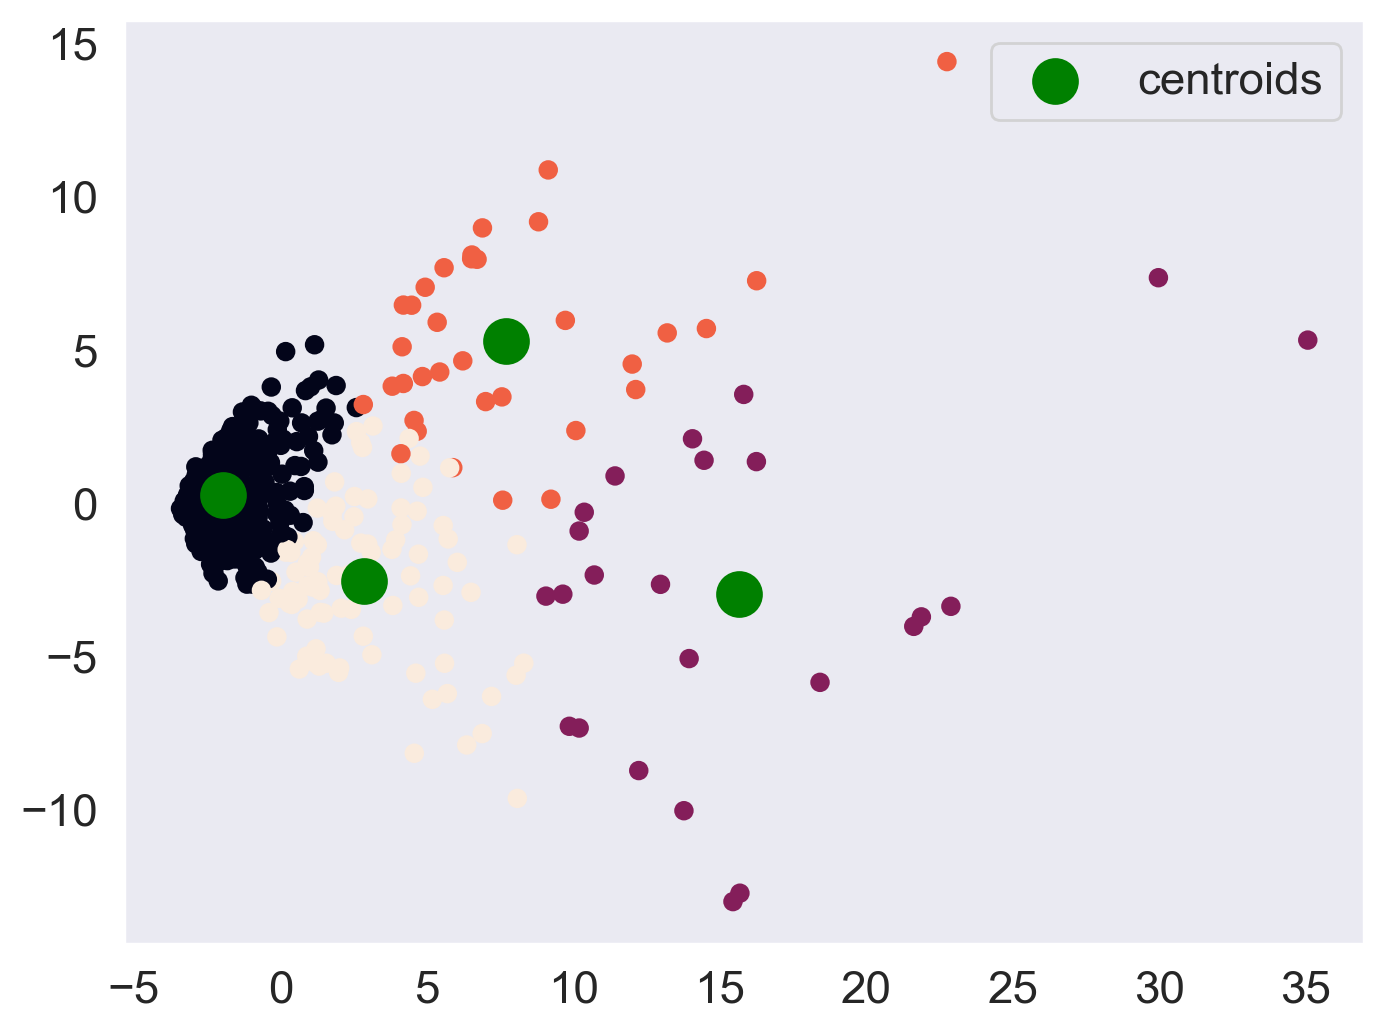

In [55]:
cluster_plot(makecluster,4)

The above plot shows the 4 different types of clusters that are formed and 4 different centroids.

In [56]:
user_movie['cluster']=c_preds
user_movie.head()

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931),cluster
userId,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Let's see the 4 clusters that users belong to.

In [57]:
cluster0 = user_movie[user_movie['cluster']==0].drop('cluster',axis=1).mean()
cluster1 = user_movie[user_movie['cluster']==1].drop('cluster',axis=1).mean()
cluster2 = user_movie[user_movie['cluster']==2].drop('cluster',axis=1).mean()
cluster3 = user_movie[user_movie['cluster']==3].drop('cluster',axis=1).mean()

Let's see what the top 20 movies in the first cluster.

In [58]:
cluster0.sort_values(ascending=False)[0:20]

title
Shawshank Redemption, The (1994)            0.453
Forrest Gump (1994)                         0.436
Pulp Fiction (1994)                         0.426
Silence of the Lambs, The (1991)            0.387
Braveheart (1995)                           0.334
Matrix, The (1999)                          0.330
Schindler's List (1993)                     0.317
Jurassic Park (1993)                        0.306
Apollo 13 (1995)                            0.289
Star Wars: Episode IV - A New Hope (1977)   0.287
Terminator 2: Judgment Day (1991)           0.283
Fugitive, The (1993)                        0.266
Toy Story (1995)                            0.255
Batman (1989)                               0.251
True Lies (1994)                            0.247
Usual Suspects, The (1995)                  0.245
Dances with Wolves (1990)                   0.243
Seven (a.k.a. Se7en) (1995)                 0.238
Independence Day (a.k.a. ID4) (1996)        0.236
Fight Club (1999)                           

I will do the same for the remaining clusters.

In [59]:
cluster1.sort_values(ascending=False)[0:20]

title
Fight Club (1999)                                                                                1.000
Harry Potter and the Sorcerer's Stone (a.k.a. Harry Potter and the Philosopher's Stone) (2001)   1.000
Pirates of the Caribbean: The Curse of the Black Pearl (2003)                                    1.000
Lord of the Rings: The Fellowship of the Ring, The (2001)                                        1.000
Lord of the Rings: The Return of the King, The (2003)                                            1.000
Star Wars: Episode I - The Phantom Menace (1999)                                                 1.000
Star Wars: Episode IV - A New Hope (1977)                                                        1.000
Star Wars: Episode V - The Empire Strikes Back (1980)                                            1.000
Star Wars: Episode VI - Return of the Jedi (1983)                                                1.000
Back to the Future (1985)                                          

In [60]:
cluster2.sort_values(ascending=False)[0:20]

title
Star Wars: Episode IV - A New Hope (1977)                                        0.951
Pulp Fiction (1994)                                                              0.927
Star Wars: Episode V - The Empire Strikes Back (1980)                            0.902
Forrest Gump (1994)                                                              0.902
Star Wars: Episode VI - Return of the Jedi (1983)                                0.902
Men in Black (a.k.a. MIB) (1997)                                                 0.902
Matrix, The (1999)                                                               0.902
Silence of the Lambs, The (1991)                                                 0.878
American Beauty (1999)                                                           0.878
Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)   0.878
Jurassic Park (1993)                                                             0.854
Sixth Sense, The (1999)              

In [61]:
cluster3.sort_values(ascending=False)[0:20]

title
Forrest Gump (1994)                                             0.866
Matrix, The (1999)                                              0.841
Lord of the Rings: The Two Towers, The (2002)                   0.756
Shrek (2001)                                                    0.756
Dark Knight, The (2008)                                         0.744
Lord of the Rings: The Fellowship of the Ring, The (2001)       0.744
Fight Club (1999)                                               0.744
Star Wars: Episode IV - A New Hope (1977)                       0.732
Pirates of the Caribbean: The Curse of the Black Pearl (2003)   0.732
Shawshank Redemption, The (1994)                                0.720
Lord of the Rings: The Return of the King, The (2003)           0.720
Kill Bill: Vol. 1 (2003)                                        0.683
Star Wars: Episode V - The Empire Strikes Back (1980)           0.671
Gladiator (2000)                                                0.659
Incredibles, T

In [62]:
def getMovieInfo(movies_list):
    list_of_genre = []
    list_of_rating= []
    
    #loop through the list of movies
    for movie in data['title']:
        if movie in movies_list:
            list_of_rating.append(data[data['title']==movie].rating.values.astype(int))
            for y in data[data['title']==movie].genres.values:
                list_of_genre.append(y)
    return list_of_genre,list_of_rating

Seeing what the list of movies were in cluster 0 (first cluster)

In [63]:
movie_list_0 = list(cluster0.sort_values(ascending=False)[0:20].index)
print(movie_list_0)

['Shawshank Redemption, The (1994)', 'Forrest Gump (1994)', 'Pulp Fiction (1994)', 'Silence of the Lambs, The (1991)', 'Braveheart (1995)', 'Matrix, The (1999)', "Schindler's List (1993)", 'Jurassic Park (1993)', 'Apollo 13 (1995)', 'Star Wars: Episode IV - A New Hope (1977)', 'Terminator 2: Judgment Day (1991)', 'Fugitive, The (1993)', 'Toy Story (1995)', 'Batman (1989)', 'True Lies (1994)', 'Usual Suspects, The (1995)', 'Dances with Wolves (1990)', 'Seven (a.k.a. Se7en) (1995)', 'Independence Day (a.k.a. ID4) (1996)', 'Fight Club (1999)']


Get a list of movies in clusters, 1,2,3

In [64]:
movie_list_1= list(cluster1.sort_values(ascending=False)[0:20].index)
movie_list_2 = list(cluster2.sort_values(ascending=False)[0:20].index)
movie_list_3 = list(cluster3.sort_values(ascending=False)[0:20].index)

In [65]:
print(movie_list_1)

['Fight Club (1999)', "Harry Potter and the Sorcerer's Stone (a.k.a. Harry Potter and the Philosopher's Stone) (2001)", 'Pirates of the Caribbean: The Curse of the Black Pearl (2003)', 'Lord of the Rings: The Fellowship of the Ring, The (2001)', 'Lord of the Rings: The Return of the King, The (2003)', 'Star Wars: Episode I - The Phantom Menace (1999)', 'Star Wars: Episode IV - A New Hope (1977)', 'Star Wars: Episode V - The Empire Strikes Back (1980)', 'Star Wars: Episode VI - Return of the Jedi (1983)', 'Back to the Future (1985)', 'Lord of the Rings: The Two Towers, The (2002)', 'Groundhog Day (1993)', 'Toy Story (1995)', 'Die Hard (1988)', '300 (2007)', 'Kill Bill: Vol. 1 (2003)', 'Kill Bill: Vol. 2 (2004)', 'Monsters, Inc. (2001)', 'X-Men (2000)', 'Incredibles, The (2004)']


In [66]:
list_of_genre_0,list_of_rating_0 =getMovieInfo(movie_list_0)
list_of_genre_1,list_of_rating_1 =getMovieInfo(movie_list_1)
list_of_genre_2,list_of_rating_2 =getMovieInfo(movie_list_2)
list_of_genre_3,list_of_rating_3 =getMovieInfo(movie_list_3)

In [67]:
list_of_genre_0[2]

'Adventure,Animation,Children,Comedy,Fantasy'

In [68]:
print(list_of_rating_0[1:2])

[array([4, 4, 4, 2, 4, 3, 4, 3, 3, 5, 3, 3, 5, 5, 3, 4, 5, 3, 3, 5, 5, 4,
       4, 2, 5, 4, 0, 4, 2, 4, 3, 3, 4, 3, 5, 4, 4, 4, 3, 3, 4, 4, 3, 2,
       3, 4, 4, 3, 4, 3, 5, 5, 2, 3, 4, 4, 4, 4, 5, 3, 4, 5, 5, 4, 4, 4,
       4, 4, 4, 2, 3, 5, 4, 5, 3, 3, 3, 4, 3, 5, 3, 3, 5, 3, 3, 5, 4, 5,
       5, 4, 4, 4, 4, 4, 2, 5, 5, 5, 4, 5, 4, 4, 3, 4, 4, 3, 4, 4, 4, 4,
       3, 2, 5, 4, 3, 3, 3, 5, 4, 4, 3, 4, 4, 4, 5, 5, 4, 5, 5, 4, 5, 5,
       3, 3, 4, 5, 3, 4, 4, 5, 3, 5, 4, 3, 5, 2, 4, 4, 4, 2, 4, 4, 4, 4,
       5, 5, 5, 5, 4, 1, 4, 4, 4, 5, 4, 4, 4, 3, 4, 4, 4, 3, 4, 4, 4, 4,
       4, 4, 3, 4, 4, 2, 3, 5, 4, 3, 3, 4, 4, 5, 3, 4, 4, 3, 4, 4, 5, 4,
       3, 5, 5, 4, 4, 4, 3, 2, 4, 4, 3, 4, 2, 4, 2, 3, 5])]


Create a function to count the key words, the number of each keyword for genres in order to illutrate a word map

In [69]:
def count_genre_word2(df, list_genre ):
    counter = dict()
    #set the counter for each genre to 0
    for gen in list_genre: counter[gen]=0
        
    for keywords in df['genre'].str.split(','):
        
        if type(keywords) == float and pd.isnull(keywords):
            continue
        for s in [s for s in keywords if s in list_genre]:
#            print("true s is in list")
            if pd.notnull(s):
                counter[s]+=1

    
    # convert the dict in a list to sort the keywords by frequency
    keyword_occurences = []
    for key,value in counter.items():
        keyword_occurences.append([key,value])
    keyword_occurences.sort(key=lambda x:x[1],reverse=True)
    return keyword_occurences, counter

In [70]:
def get_set_keywords(data):
    set_keywords=set()
    for l in data['genre'].str.split(',').values:
        if isinstance(l,float):continue
        set_keywords = set_keywords.union(l)
    return set_keywords

In [71]:
data_cluster_0 = pd.DataFrame()
data_cluster_0['genre']=list_of_genre_0

data_cluster_1 = pd.DataFrame()
data_cluster_1['genre']=list_of_genre_1

data_cluster_2 = pd.DataFrame()
data_cluster_2['genre']=list_of_genre_2

data_cluster_3 = pd.DataFrame()
data_cluster_3['genre']=list_of_genre_3
test_cluster =pd.DataFrame()
test_cluster['genre']=data_cluster_0['genre'][0:3]

In [72]:
print(data_cluster_0)

                                               genre
0        Adventure,Animation,Children,Comedy,Fantasy
1        Adventure,Animation,Children,Comedy,Fantasy
2        Adventure,Animation,Children,Comedy,Fantasy
3        Adventure,Animation,Children,Comedy,Fantasy
4        Adventure,Animation,Children,Comedy,Fantasy
...                                              ...
1120669                  Action,Crime,Drama,Thriller
1120670                  Action,Crime,Drama,Thriller
1120671                  Action,Crime,Drama,Thriller
1120672                  Action,Crime,Drama,Thriller
1120673                  Action,Crime,Drama,Thriller

[1120674 rows x 1 columns]


In [73]:
print(test_cluster)

                                         genre
0  Adventure,Animation,Children,Comedy,Fantasy
1  Adventure,Animation,Children,Comedy,Fantasy
2  Adventure,Animation,Children,Comedy,Fantasy


In [74]:
test_set_keywords= get_set_keywords(test_cluster)

In [75]:
print(test_set_keywords)

{'Fantasy', 'Comedy', 'Adventure', 'Children', 'Animation'}


In [76]:
test_keyword_occ0, test_dum0 = count_genre_word2(test_cluster,test_set_keywords)

In [77]:
set_keywords_0= get_set_keywords(data_cluster_0)
set_keywords_1= get_set_keywords(data_cluster_1)
set_keywords_2= get_set_keywords(data_cluster_2)
set_keywords_3= get_set_keywords(data_cluster_3)

In [78]:
print(test_keyword_occ0)

[['Fantasy', 3], ['Comedy', 3], ['Adventure', 3], ['Children', 3], ['Animation', 3]]


In [79]:
print(data_cluster_1['genre'])

0         Adventure,Animation,Children,Comedy,Fantasy
1         Adventure,Animation,Children,Comedy,Fantasy
2         Adventure,Animation,Children,Comedy,Fantasy
3         Adventure,Animation,Children,Comedy,Fantasy
4         Adventure,Animation,Children,Comedy,Fantasy
                             ...                     
558819                        Action,Fantasy,War,IMAX
558820                        Action,Fantasy,War,IMAX
558821                        Action,Fantasy,War,IMAX
558822                        Action,Fantasy,War,IMAX
558823                        Action,Fantasy,War,IMAX
Name: genre, Length: 558824, dtype: object


In [80]:
print(set_keywords_0)
# print(set_keywords_1)
# print(set_keywords_2)
# print(set_keywords_3)

{'Horror', 'War', 'Drama', 'Fantasy', 'Adventure', 'IMAX', 'Sci-Fi', 'Romance', 'Crime', 'Mystery', 'Action', 'Comedy', 'Animation', 'Western', 'Children', 'Thriller'}


In [81]:
print(data_cluster_0)

                                               genre
0        Adventure,Animation,Children,Comedy,Fantasy
1        Adventure,Animation,Children,Comedy,Fantasy
2        Adventure,Animation,Children,Comedy,Fantasy
3        Adventure,Animation,Children,Comedy,Fantasy
4        Adventure,Animation,Children,Comedy,Fantasy
...                                              ...
1120669                  Action,Crime,Drama,Thriller
1120670                  Action,Crime,Drama,Thriller
1120671                  Action,Crime,Drama,Thriller
1120672                  Action,Crime,Drama,Thriller
1120673                  Action,Crime,Drama,Thriller

[1120674 rows x 1 columns]


In [82]:
keyword_occ0, dum0 = count_genre_word2(data_cluster_0,set_keywords_0)
keyword_occ1, dum1 = count_genre_word2(data_cluster_1,set_keywords_1)
keyword_occ2, dum2 = count_genre_word2(data_cluster_2,set_keywords_2)
keyword_occ3, dum3 = count_genre_word2(data_cluster_3,set_keywords_3)

In [83]:
print(data_cluster_1)

                                              genre
0       Adventure,Animation,Children,Comedy,Fantasy
1       Adventure,Animation,Children,Comedy,Fantasy
2       Adventure,Animation,Children,Comedy,Fantasy
3       Adventure,Animation,Children,Comedy,Fantasy
4       Adventure,Animation,Children,Comedy,Fantasy
...                                             ...
558819                      Action,Fantasy,War,IMAX
558820                      Action,Fantasy,War,IMAX
558821                      Action,Fantasy,War,IMAX
558822                      Action,Fantasy,War,IMAX
558823                      Action,Fantasy,War,IMAX

[558824 rows x 1 columns]


In [84]:
def makeCloud(Dict,name,color):
    words = dict()

    for s in Dict:
        words[s[0]] = s[1]
        wordcloud = WordCloud(
                      width=1500,
                      height=500, 
                      background_color=color, 
                      max_words=20,
                      max_font_size=500, 
                      normalize_plurals=False)
        wordcloud.generate_from_frequencies(words)
        
    fig = plt.figure(figsize=(12, 8))
    plt.title(name)
    plt.imshow(wordcloud)
    plt.axis('off')

    plt.show()

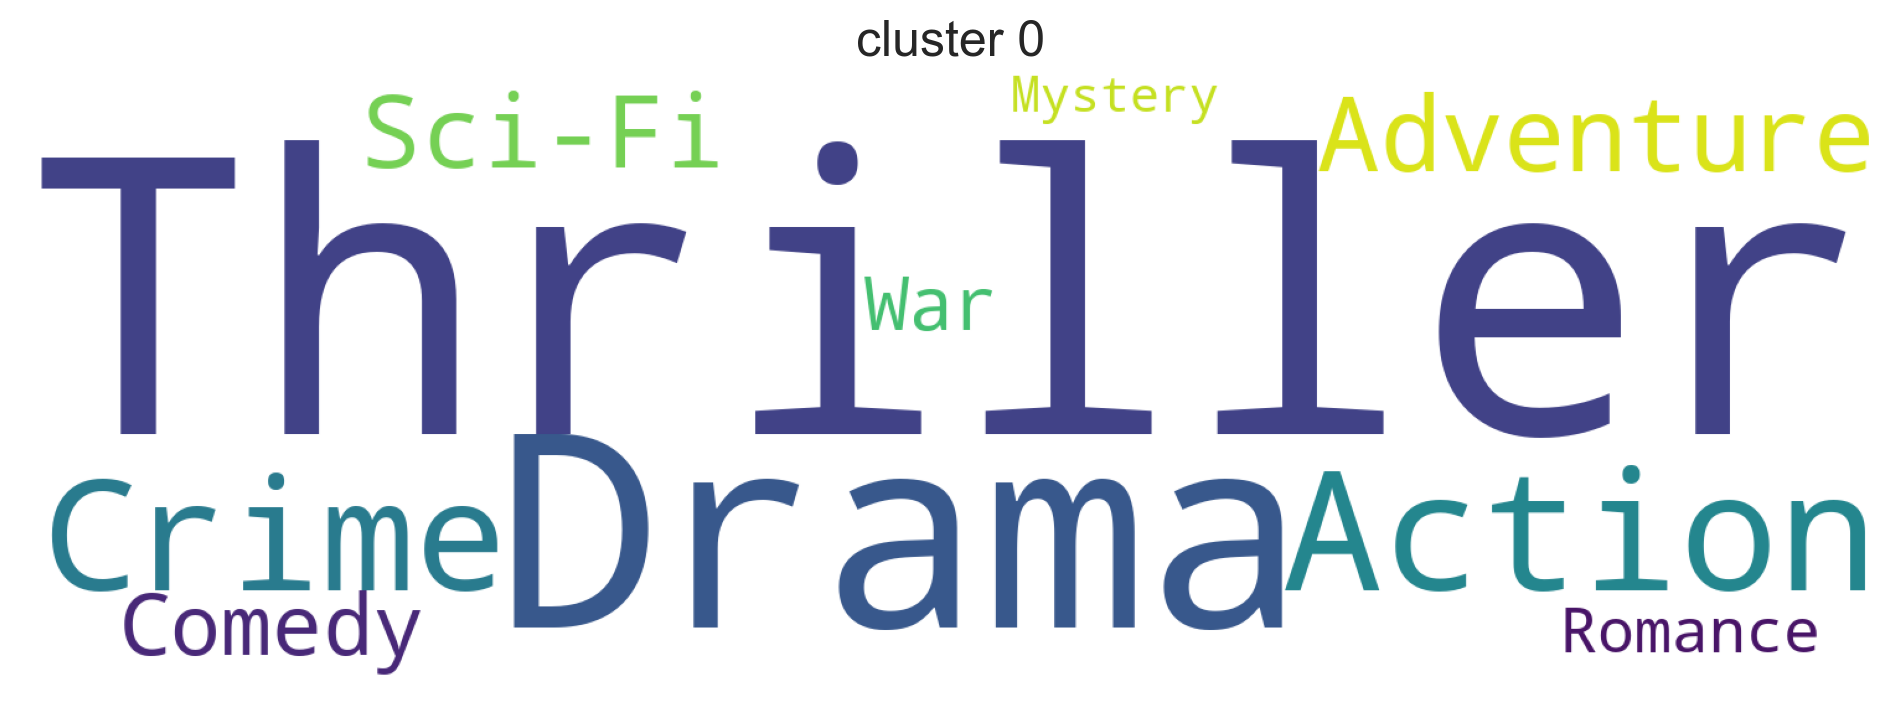

In [85]:
makeCloud(keyword_occ0[0:10],"cluster 0","white")

In [86]:
print(keyword_occ0[0:27])

[['Thriller', 580676], ['Drama', 522369], ['Action', 459007], ['Crime', 397440], ['Adventure', 305655], ['Sci-Fi', 287909], ['Comedy', 280399], ['War', 212810], ['Romance', 139925], ['Mystery', 82825], ['Horror', 77841], ['Fantasy', 46225], ['Animation', 46225], ['Children', 46225], ['IMAX', 40401], ['Western', 26896]]


As we can see in this cloud map, the top 10 genres in cluster 0.

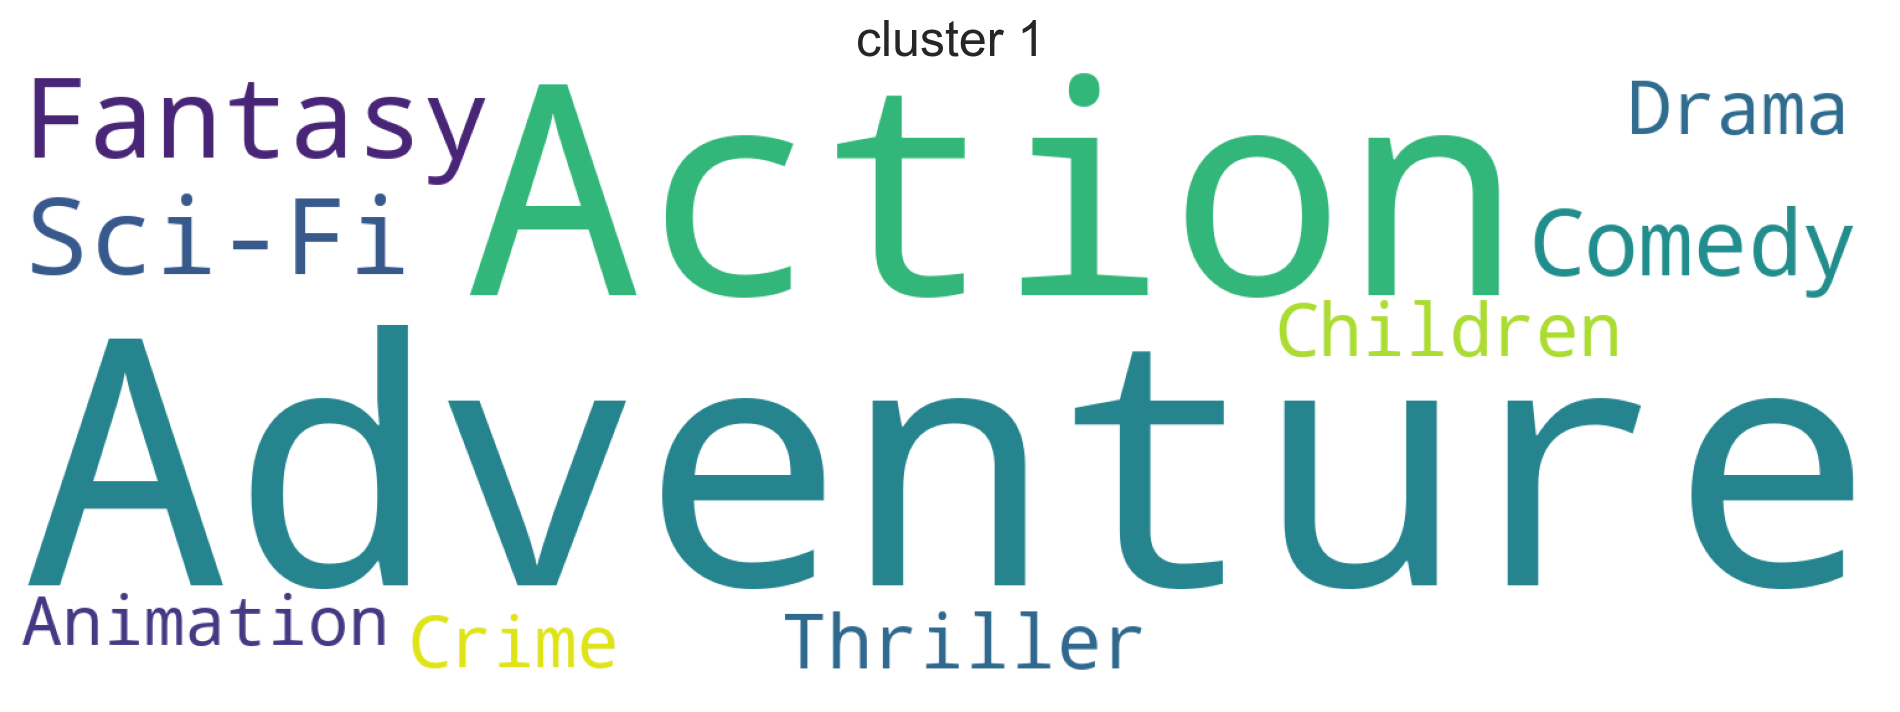

In [87]:
makeCloud(keyword_occ1[0:10],"cluster 1","white")

In [88]:
print(keyword_occ1[0:27])

[['Adventure', 434165], ['Action', 359488], ['Fantasy', 232921], ['Sci-Fi', 212468], ['Comedy', 151165], ['Thriller', 97810], ['Drama', 93849], ['Children', 90723], ['Crime', 85710], ['Animation', 79274], ['Romance', 20449], ['IMAX', 6400], ['War', 6400]]


As we can see in this cloud map, the top 10 genres in cluster 1.

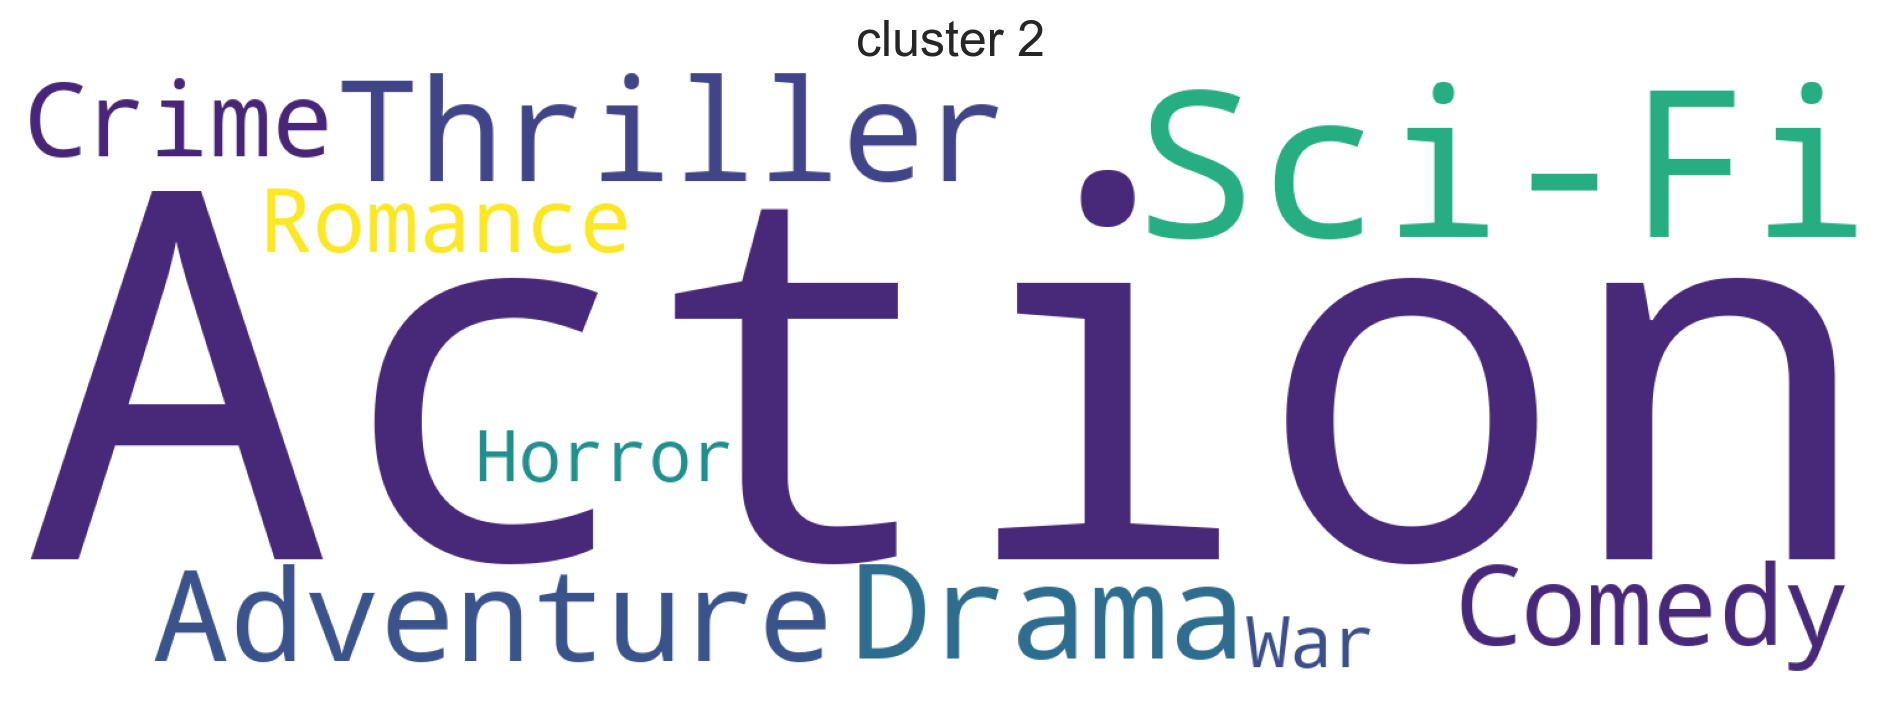

In [89]:
makeCloud(keyword_occ2[0:10],"cluster 2","white")

In [90]:
print(keyword_occ2[0:27])

[['Action', 486496], ['Sci-Fi', 434832], ['Thriller', 396744], ['Drama', 345772], ['Adventure', 314650], ['Comedy', 282925], ['Crime', 241715], ['Romance', 170306], ['Horror', 109882], ['War', 108241], ['Fantasy', 32113], ['Mystery', 32041]]


As we can see in this cloud map, the top 10 genres in cluster 2.

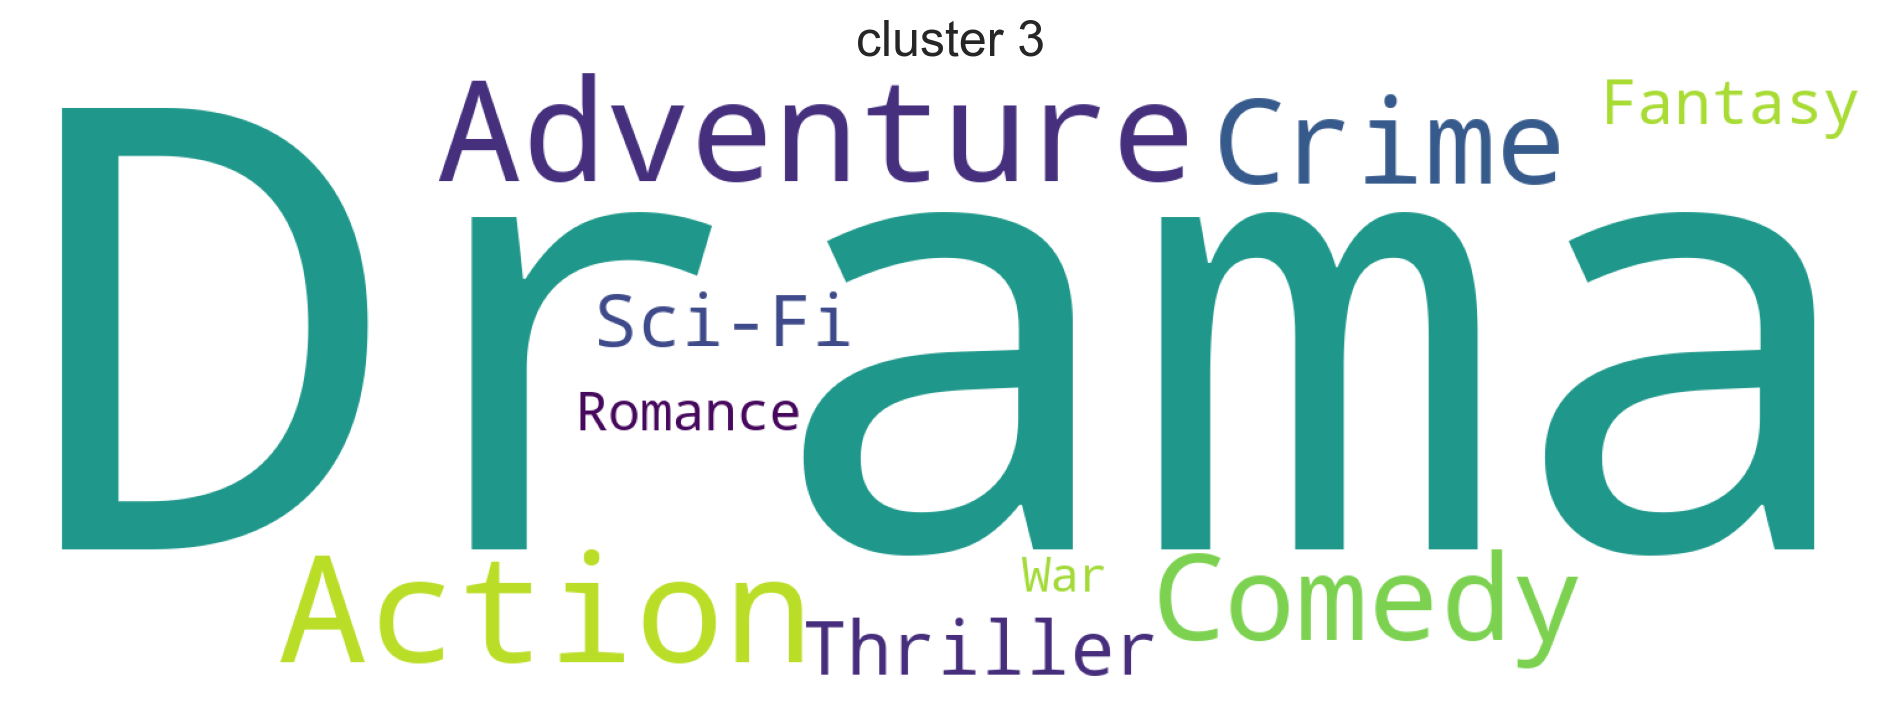

In [91]:
makeCloud(keyword_occ3[0:10],"cluster 3","white")

In [92]:
print(keyword_occ3[0:27])

[['Drama', 456278], ['Action', 431508], ['Adventure', 387642], ['Comedy', 306521], ['Crime', 302073], ['Thriller', 256667], ['Sci-Fi', 243671], ['Fantasy', 177298], ['Romance', 137141], ['War', 108241], ['Animation', 81830], ['Children', 81830], ['IMAX', 42650], ['Mystery', 20449]]


As we can see in this cloud map, the top 10 genres in cluster 3.

In [93]:
print(user_movie['cluster'])

userId
1      0
2      0
3      0
4      0
5      0
      ..
606    2
607    0
608    1
609    0
610    1
Name: cluster, Length: 610, dtype: int32


In [94]:
dfu = pd.DataFrame(user_movie['cluster'])
print(dfu)

        cluster
userId         
1             0
2             0
3             0
4             0
5             0
...         ...
606           2
607           0
608           1
609           0
610           1

[610 rows x 1 columns]


Filtering based on cluster

In [95]:
rslt_df = dfu[dfu["cluster"]==1]
print(rslt_df)

        cluster
userId         
68            1
177           1
219           1
232           1
249           1
274           1
298           1
307           1
380           1
414           1
438           1
448           1
480           1
483           1
599           1
608           1
610           1


This shows the cluster user 3 and 391 belongs to

In [96]:
print(user_movie.at[3,"cluster"])
print(user_movie.at[391,"cluster"])

0
2


In [97]:
ratings_origin = pd.read_csv('ratings.csv')
ratings_origin.head()

,userId,movieId,rating,timestamp
0,1,1,4.000,964982703
1,1,3,4.000,964981247
2,1,6,4.000,964982224
3,1,47,5.000,964983815
4,1,50,5.000,964982931


In [98]:
# Get a list of user X has watched

def getListMovieOfUserX(userId):
    new_user_tab=ratings_origin[ratings_origin['userId']==userId]
    return new_user_tab["movieId"].tolist()

# list_userX_movie = getListMovieOfUserX(userId)

In [99]:
list_userX_movie = getListMovieOfUserX(3)

In [100]:
print(list_userX_movie)

[31, 527, 647, 688, 720, 849, 914, 1093, 1124, 1263, 1272, 1275, 1302, 1371, 1587, 2018, 2080, 2090, 2105, 2288, 2424, 2851, 3024, 3210, 3703, 3949, 4518, 5048, 5181, 5746, 5764, 5919, 6238, 6835, 7899, 7991, 26409, 70946, 72378]


In [101]:
# get the cluster# of user X
def getClusterID(userId):
    return user_movie.at[userId,"cluster"]

In [102]:
movie_list=movies_df["movieId"].tolist()

In [103]:
print(movie_list)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34, 36, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 52, 53, 54, 55, 57, 58, 60, 61, 62, 63, 64, 65, 66, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 85, 86, 87, 88, 89, 92, 93, 94, 95, 96, 97, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 110, 111, 112, 113, 116, 117, 118, 119, 121, 122, 123, 125, 126, 128, 129, 132, 135, 137, 140, 141, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 183, 184, 185, 186, 187, 188, 189, 190, 191, 193, 194, 195, 196, 198, 199, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 222, 223, 224, 225, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 246, 247, 248, 249, 250, 251, 252, 253, 254, 2

In [104]:
# Get a list of movie that user X has not watched
def notWatchedList(movie_list, watched_list):
    new_list = []
    for m in movie_list:
        if m not in watched_list:
            new_list.append(m)
    return new_list

In [105]:
notwatched = notWatchedList(movie_list,list_userX_movie)

In [106]:
print(notwatched)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32, 34, 36, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 52, 53, 54, 55, 57, 58, 60, 61, 62, 63, 64, 65, 66, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 85, 86, 87, 88, 89, 92, 93, 94, 95, 96, 97, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 110, 111, 112, 113, 116, 117, 118, 119, 121, 122, 123, 125, 126, 128, 129, 132, 135, 137, 140, 141, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 183, 184, 185, 186, 187, 188, 189, 190, 191, 193, 194, 195, 196, 198, 199, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 222, 223, 224, 225, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 

In [107]:
#Get top 25 movies in each cluster
def top_movie_in_clusterX(clusterID):
    lis = []
    if clusterID==0:
        print("cluster0")
        lis = cluster0.sort_values(ascending=False)[0:24]
    elif clusterID==1:
        print("cluster1")
        lis = cluster1.sort_values(ascending=False)[0:24]
    elif clusterID==2:
        print("cluster2")
        lis = cluster2.sort_values(ascending=False)[0:24]
    elif clusterID==3:
        print("cluster3")
        lis = cluster3.sort_values(ascending=False)[0:24]
    return lis.index.tolist()

In [108]:
top_25_movie_incluster = top_movie_in_clusterX(getClusterID(610))

cluster1


user 610 is is in cluster 2, and these are cluster 2's top 25 movies

In [109]:
print(top_25_movie_incluster)

['Fight Club (1999)', "Harry Potter and the Sorcerer's Stone (a.k.a. Harry Potter and the Philosopher's Stone) (2001)", 'Pirates of the Caribbean: The Curse of the Black Pearl (2003)', 'Lord of the Rings: The Fellowship of the Ring, The (2001)', 'Lord of the Rings: The Return of the King, The (2003)', 'Star Wars: Episode I - The Phantom Menace (1999)', 'Star Wars: Episode IV - A New Hope (1977)', 'Star Wars: Episode V - The Empire Strikes Back (1980)', 'Star Wars: Episode VI - Return of the Jedi (1983)', 'Back to the Future (1985)', 'Lord of the Rings: The Two Towers, The (2002)', 'Groundhog Day (1993)', 'Toy Story (1995)', 'Die Hard (1988)', '300 (2007)', 'Kill Bill: Vol. 1 (2003)', 'Kill Bill: Vol. 2 (2004)', 'Monsters, Inc. (2001)', 'X-Men (2000)', 'Incredibles, The (2004)', 'Independence Day (a.k.a. ID4) (1996)', 'Catch Me If You Can (2002)', 'Matrix, The (1999)', 'Jurassic Park (1993)']


In [110]:
type(top_25_movie_incluster)

list

In [111]:
# get info of top 25 movies in cluster that given user belong to
def getMoviesId(list_movie):
    new_rec_list ={}
    lis =[]
    for m in list_movie:
        id = movies_df[movies_df["title"]==m]['movieId']
        new_rec_list[m]=id
        
    for k, v in new_rec_list.items():
        lis.append(v.tolist())
    return new_rec_list,lis

In [112]:
dict_top_25_movies,top_25_movies = getMoviesId(top_25_movie_incluster)
print(dict_top_25_movies)

{'Fight Club (1999)': 2226    2959
Name: movieId, dtype: int64, "Harry Potter and the Sorcerer's Stone (a.k.a. Harry Potter and the Philosopher's Stone) (2001)": 3574    4896
Name: movieId, dtype: int64, 'Pirates of the Caribbean: The Curse of the Black Pearl (2003)': 4427    6539
Name: movieId, dtype: int64, 'Lord of the Rings: The Fellowship of the Ring, The (2001)': 3638    4993
Name: movieId, dtype: int64, 'Lord of the Rings: The Return of the King, The (2003)': 4800    7153
Name: movieId, dtype: int64, 'Star Wars: Episode I - The Phantom Menace (1999)': 1979    2628
Name: movieId, dtype: int64, 'Star Wars: Episode IV - A New Hope (1977)': 224    260
Name: movieId, dtype: int64, 'Star Wars: Episode V - The Empire Strikes Back (1980)': 898    1196
Name: movieId, dtype: int64, 'Star Wars: Episode VI - Return of the Jedi (1983)': 911    1210
Name: movieId, dtype: int64, 'Back to the Future (1985)': 969    1270
Name: movieId, dtype: int64, 'Lord of the Rings: The Two Towers, The (2002)

In [113]:
# unwatched is the list of movie user 1 has not watched.
# moviesWatchedInCluster is the dictionnairy of movie in cluster which user X belongs to

# top_rec is the list of movie in cluster of user X that user X is recommended to watch

def recommendation_movie(notwatched, moviesWatchedInCluster):
    top_rec = {}
    for k,v in moviesWatchedInCluster.items():
        if v.item() in notwatched:
            top_rec[k]=v.item()
    return top_rec

In [114]:
top_rec = recommendation_movie(notwatched,dict_top_25_movies)

In [115]:
def final_recommendation_system(userId):
    # get a list of movie user X has watched
    list_userX_movie = getListMovieOfUserX(userId)
    # get cluster ID (int)
    clusterId= getClusterID(userId)
    print(clusterId)
    # Get a list of movie that user X has not watched
    notwatched = notWatchedList(movie_list,list_userX_movie)
    # Get a list of top movies in cluster that user X belong to
    top_movie_incluster = top_movie_in_clusterX(clusterId)
    # get info of top movies in cluster that given user belong to
    dict_top_movies,top_movies = getMoviesId(top_movie_incluster)
    top_rec=recommendation_movie(notwatched, dict_top_movies)
    rec_table = pd.DataFrame(top_rec.items(),columns=['Title', 'movieId'])
    print(rec_table)
    return rec_table

The main function to get the list of recommended movies to a user...in this example, user 3.

In [116]:
final_recommendation_system(3)

0
cluster0
                                        Title  movieId
0            Shawshank Redemption, The (1994)      318
1                         Forrest Gump (1994)      356
2                         Pulp Fiction (1994)      296
3            Silence of the Lambs, The (1991)      593
4                           Braveheart (1995)      110
5                          Matrix, The (1999)     2571
6                        Jurassic Park (1993)      480
7                            Apollo 13 (1995)      150
8   Star Wars: Episode IV - A New Hope (1977)      260
9           Terminator 2: Judgment Day (1991)      589
10                       Fugitive, The (1993)      457
11                           Toy Story (1995)        1
12                              Batman (1989)      592
13                           True Lies (1994)      380
14                 Usual Suspects, The (1995)       50
15                  Dances with Wolves (1990)      590
16                Seven (a.k.a. Se7en) (1995)       47

,Title,movieId
0,"Shawshank Redemption, The (1994)",318
1,Forrest Gump (1994),356
2,Pulp Fiction (1994),296
3,"Silence of the Lambs, The (1991)",593
4,Braveheart (1995),110
5,"Matrix, The (1999)",2571
6,Jurassic Park (1993),480
7,Apollo 13 (1995),150
8,Star Wars: Episode IV - A New Hope (1977),260
9,Terminator 2: Judgment Day (1991),589


## 7. Collaborative Filtering <a id='rec_sys'></a>

#### Merging data frames

<table align="center" width=60%>
    <tr>
        <td width="25%">
            <img src="memory based.jpg">
        </td>
    </tr>
</table>

In [117]:
movie_rating = pd.merge(movies_df,ratings_df, how='left', on='movieId')

In [118]:
##Dropping the duplicates based on userid and title to create user item interaction matrix
movie_rating = movie_rating.drop_duplicates(['userId', 'title'])

In [119]:
movie_rating.isnull().sum()

movieId                0
title                  0
genres                 0
(no genres listed)     0
Action                 0
Adventure              0
Animation              0
Children               0
Comedy                 0
Crime                  0
Documentary            0
Drama                  0
Fantasy                0
Film-Noir              0
Horror                 0
IMAX                   0
Musical                0
Mystery                0
Romance                0
Sci-Fi                 0
Thriller               0
War                    0
Western                0
year                  18
userId                18
rating                18
dtype: int64

In [120]:
movie_rating.dropna(inplace=True)

In [121]:
movie_rating.reset_index(inplace=True,drop=True)

In [122]:
movie_rating['userId']=movie_rating['userId'].astype('int64')

In [123]:
movie_rating.head()

,movieId,title,genres,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,...,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,year,userId,rating
0,1,Toy Story (1995),"Adventure,Animation,Children,Comedy,Fantasy",0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,1995,1,4.000
1,1,Toy Story (1995),"Adventure,Animation,Children,Comedy,Fantasy",0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,1995,5,4.000
2,1,Toy Story (1995),"Adventure,Animation,Children,Comedy,Fantasy",0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,1995,7,4.500
3,1,Toy Story (1995),"Adventure,Animation,Children,Comedy,Fantasy",0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,1995,15,2.500
4,1,Toy Story (1995),"Adventure,Animation,Children,Comedy,Fantasy",0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,1995,17,4.500


Creating a dataframe to show the number of ratings for each movie sorted by total in descending order along with the mean ratings of each movie

In [124]:
df_ratings = pd.DataFrame(ratings_origin.groupby('movieId')['rating'].mean())
df_ratings['total ratings']=pd.DataFrame(ratings_origin.groupby('movieId')['rating'].count())
df_ratings.rename(columns={'rating':'mean ratings'},inplace=True)
df_ratings.sort_values('total ratings', ascending=False).head(10)

,mean ratings,total ratings
movieId,,
356,4.164,329
318,4.429,317
296,4.197,307
593,4.161,279
2571,4.192,278
260,4.231,251
480,3.750,238
110,4.032,237
589,3.971,224


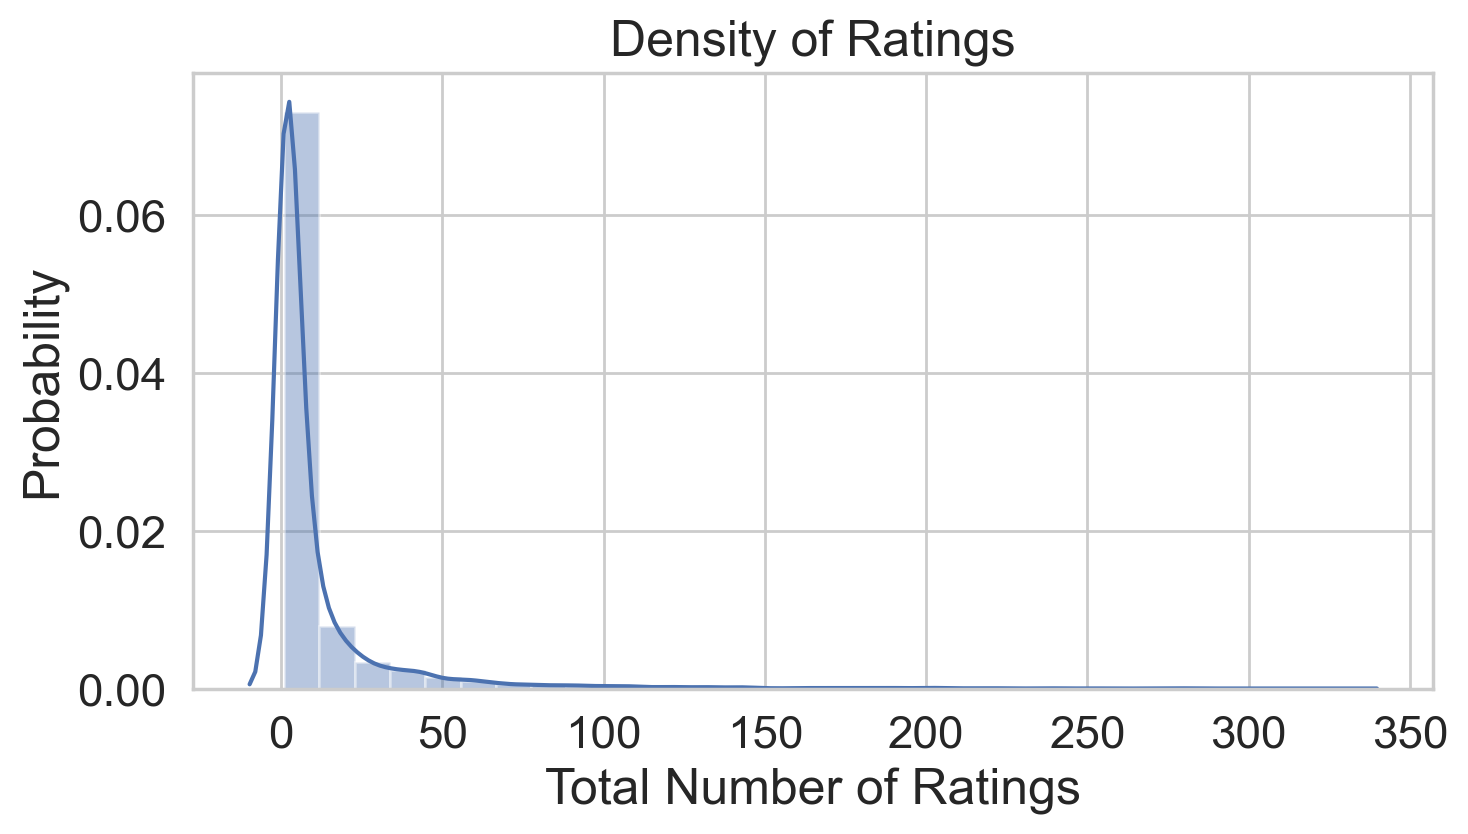

In [125]:
plt.figure(figsize=(8,4))
sns.set_style("whitegrid")
sns.distplot(df_ratings['total ratings'], bins=30)
plt.title('Density of Ratings')
plt.xlabel('Total Number of Ratings')
plt.ylabel('Probability')
plt.show()

Looking at this density plot, we can see that the majority of movies have less than 50 ratings.

## 7.1 Collaborative Filtering 

Collaborative filtering is a technique that can filter out items that a user might like on the basis of reactions by similar users. It works by searching a large group of people and finding a smaller set of users with tastes similar to a particular user.

User-Item Collaborative Filtering: “Users who are similar to you also liked …”

#### User-Item

In [126]:
##Dropping the duplicates based on userid and title to create user item interaction matrix
movie_rating = movie_rating.drop_duplicates(['userId', 'title'])

In [127]:
movie_rating.shape #shape of the dataset upon dropping the duplicates

(100814, 26)

In [128]:
##Calculating the rating count for each movie 
movie_rating_count = movie_rating.groupby('title').agg('count').reset_index().iloc[:,[0,4]]
movie_rating_count = movie_rating_count.rename(columns={'Action': 'MovieRatingCount'})
movie_rating_count.head(10)

,title,MovieRatingCount
0,'71 (2014),1
1,'Hellboy': The Seeds of Creation (2004),1
2,'Round Midnight (1986),2
3,'Salem's Lot (2004),1
4,'Til There Was You (1997),2
5,'Tis the Season for Love (2015),1
6,"'burbs, The (1989)",17
7,'night Mother (1986),1
8,(500) Days of Summer (2009),42
9,*batteries not included (1987),7


In [129]:
##Merging the rating count column with main dataset
movie_rating_count = pd.merge(movie_rating, movie_rating_count, how='left', on='title')
movie_rating_count.head()

,movieId,title,genres,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,...,Mystery,Romance,Sci-Fi,Thriller,War,Western,year,userId,rating,MovieRatingCount
0,1,Toy Story (1995),"Adventure,Animation,Children,Comedy,Fantasy",0,0,1,1,1,1,0,...,0,0,0,0,0,0,1995,1,4.000,215
1,1,Toy Story (1995),"Adventure,Animation,Children,Comedy,Fantasy",0,0,1,1,1,1,0,...,0,0,0,0,0,0,1995,5,4.000,215
2,1,Toy Story (1995),"Adventure,Animation,Children,Comedy,Fantasy",0,0,1,1,1,1,0,...,0,0,0,0,0,0,1995,7,4.500,215
3,1,Toy Story (1995),"Adventure,Animation,Children,Comedy,Fantasy",0,0,1,1,1,1,0,...,0,0,0,0,0,0,1995,15,2.500,215
4,1,Toy Story (1995),"Adventure,Animation,Children,Comedy,Fantasy",0,0,1,1,1,1,0,...,0,0,0,0,0,0,1995,17,4.500,215


Creating a dataframe to store every movie's total ratings and the mean for the ratings.

In [130]:
movie_rating_count.describe()

,movieId,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,...,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,userId,rating,MovieRatingCount
count,100814.000,100814.000,100814.000,100814.000,100814.000,100814.000,100814.000,100814.000,100814.000,100814.000,...,100814.000,100814.000,100814.000,100814.000,100814.000,100814.000,100814.000,100814.000,100814.000,100814.000
mean,19410.690,0.000,0.304,0.240,0.069,0.091,0.387,0.165,0.012,0.416,...,0.041,0.076,0.180,0.171,0.262,0.048,0.019,326.135,3.502,58.768
std,35488.741,0.019,0.460,0.427,0.254,0.288,0.487,0.372,0.109,0.493,...,0.198,0.265,0.384,0.376,0.440,0.214,0.137,182.617,1.042,61.968
min,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.500,1.000
25%,1199.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,177.000,3.000,13.000
50%,2991.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,325.000,3.500,39.000
75%,8042.000,0.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000,1.000,...,0.000,0.000,0.000,0.000,1.000,0.000,0.000,477.000,4.000,84.000
max,193609.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,...,1.000,1.000,1.000,1.000,1.000,1.000,1.000,610.000,5.000,329.000


For further analysis considering the data for movie rating count to be greather than the 50% percentile.Which means atleast 50 users should have been rated the movie.

In [131]:
movie_rating_count2 = movie_rating_count[movie_rating_count['MovieRatingCount']>=50]

In [132]:
##Creating the pivot table with greater than 50 movie rating count
user_item_matrix = movie_rating_count2.pivot(index='userId',columns='title', values='rating')
user_item_matrix = user_item_matrix.fillna(0)
user_item_matrix.head()    ##User-item interaction matrix

title,10 Things I Hate About You (1999),12 Angry Men (1957),2001: A Space Odyssey (1968),28 Days Later (2002),300 (2007),"40-Year-Old Virgin, The (2005)",A.I. Artificial Intelligence (2001),"Abyss, The (1989)",Ace Ventura: Pet Detective (1994),Ace Ventura: When Nature Calls (1995),...,Willy Wonka & the Chocolate Factory (1971),"Wizard of Oz, The (1939)","Wolf of Wall Street, The (2013)",X-Men (2000),X-Men: The Last Stand (2006),X2: X-Men United (2003),You've Got Mail (1998),Young Frankenstein (1974),Zombieland (2009),Zoolander (2001)
userId,,,,,,,,,,,,,,,,,,,,,
1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,4.000,0.000,0.000,...,5.000,5.000,0.000,5.000,0.000,0.000,0.000,5.000,0.000,0.000
2,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,5.000,0.000,0.000,0.000,0.000,0.000,3.000,0.000
3,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.500,0.000,0.000,0.000
4,0.000,5.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,4.000,5.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
5,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,3.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [133]:
# User based collaborative filtering
user_user_matrix = user_item_matrix.copy()
user_user_matrix.head(5)

title,10 Things I Hate About You (1999),12 Angry Men (1957),2001: A Space Odyssey (1968),28 Days Later (2002),300 (2007),"40-Year-Old Virgin, The (2005)",A.I. Artificial Intelligence (2001),"Abyss, The (1989)",Ace Ventura: Pet Detective (1994),Ace Ventura: When Nature Calls (1995),...,Willy Wonka & the Chocolate Factory (1971),"Wizard of Oz, The (1939)","Wolf of Wall Street, The (2013)",X-Men (2000),X-Men: The Last Stand (2006),X2: X-Men United (2003),You've Got Mail (1998),Young Frankenstein (1974),Zombieland (2009),Zoolander (2001)
userId,,,,,,,,,,,,,,,,,,,,,
1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,4.000,0.000,0.000,...,5.000,5.000,0.000,5.000,0.000,0.000,0.000,5.000,0.000,0.000
2,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,5.000,0.000,0.000,0.000,0.000,0.000,3.000,0.000
3,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.500,0.000,0.000,0.000
4,0.000,5.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,4.000,5.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
5,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,3.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [134]:
user_user_matrix.T.corr()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
userId,,,,,,,,,,,,,,,,,,,,,
1,1.000,-0.043,0.057,0.239,0.097,0.028,0.065,0.060,0.061,-0.122,...,-0.091,0.068,0.286,-0.051,0.082,0.078,0.249,0.167,0.056,-0.009
2,-0.043,1.000,-0.017,-0.071,-0.021,-0.022,-0.067,-0.015,-0.031,0.128,...,0.289,-0.050,-0.094,-0.064,-0.078,-0.062,-0.066,-0.094,0.007,0.126
3,0.057,-0.017,1.000,-0.041,0.028,-0.027,-0.044,0.018,-0.016,-0.028,...,-0.010,-0.006,-0.045,-0.033,-0.040,-0.049,0.003,0.037,-0.022,-0.063
4,0.239,-0.071,-0.041,1.000,0.018,-0.038,0.027,-0.016,-0.044,-0.044,...,-0.009,-0.010,0.336,-0.043,0.030,0.110,0.083,0.038,-0.055,-0.031
5,0.097,-0.021,0.028,0.018,1.000,0.449,0.022,0.483,-0.047,-0.011,...,-0.016,0.499,0.043,0.310,0.194,-0.011,0.145,0.058,0.340,-0.064
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,0.078,-0.062,-0.049,0.110,-0.011,-0.159,0.215,-0.014,0.108,0.040,...,0.172,-0.074,0.225,-0.124,0.093,1.000,-0.000,0.128,-0.022,0.180
607,0.249,-0.066,0.003,0.083,0.145,0.120,0.118,0.147,-0.060,-0.123,...,-0.047,0.156,0.228,0.058,0.069,-0.000,1.000,0.161,0.168,0.013
608,0.167,-0.094,0.037,0.038,0.058,-0.019,0.296,0.101,0.060,-0.065,...,-0.063,0.037,0.134,0.002,0.025,0.128,0.161,1.000,0.071,0.127


In [135]:
user_correlation_matrix = user_user_matrix.T.corr()

In [136]:
#Get corraltion values between users to user 1.

def getCorrValUser(userId):
    corr_user_X=user_correlation_matrix.iloc[userId-1]
    corr_user_X.sort_values(ascending=False, inplace=True)
    #Keep the DataFrame with valid entries in the same variable. Drop all NaN entries
    corr_user_X.dropna(inplace=True)
    return corr_user_X

In [137]:
userId=1

In [138]:
corr_user_222 = getCorrValUser(222)
print(corr_user_222)

userId
224    1.000
367    0.343
275    0.322
201    0.303
597    0.293
       ...  
18    -0.084
73    -0.085
139   -0.091
405   -0.098
393   -0.111
Name: 224, Length: 606, dtype: float64


In [139]:
# get the top 50 users 
def getTopUserCorr(corr_user_X):  
    top_users = corr_user_X[1:51]
    return top_users

In [140]:
movie_rating_count[movie_rating_count['userId']==userId]

,movieId,title,genres,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,...,Mystery,Romance,Sci-Fi,Thriller,War,Western,year,userId,rating,MovieRatingCount
0,1,Toy Story (1995),"Adventure,Animation,Children,Comedy,Fantasy",0,0,1,1,1,1,0,...,0,0,0,0,0,0,1995,1,4.000,215
325,3,Grumpier Old Men (1995),"Comedy,Romance",0,0,0,0,0,1,0,...,0,1,0,0,0,0,1995,1,4.000,52
433,6,Heat (1995),"Action,Crime,Thriller",0,1,0,0,0,0,1,...,0,0,0,1,0,0,1995,1,4.000,102
2107,47,Seven (a.k.a. Se7en) (1995),"Mystery,Thriller",0,0,0,0,0,0,0,...,1,0,0,1,0,0,1995,1,5.000,203
2379,50,"Usual Suspects, The (1995)","Crime,Mystery,Thriller",0,0,0,0,0,0,1,...,1,0,0,1,0,0,1995,1,5.000,204
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56816,3744,Shaft (2000),"Action,Crime,Thriller",0,1,0,0,0,0,1,...,0,0,0,1,0,0,2000,1,4.000,19
57276,3793,X-Men (2000),"Action,Adventure,Sci-Fi",0,1,1,0,0,0,0,...,0,0,1,0,0,0,2000,1,5.000,133
57457,3809,What About Bob? (1991),Comedy,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1991,1,4.000,35
59170,4006,Transformers: The Movie (1986),"Adventure,Animation,Children,Sci-Fi",0,0,1,1,1,0,0,...,0,0,1,0,0,0,1986,1,4.000,7


As an example, user X has not watched the movie with a movieId of 365, Forest Gump. We can calculate what rating user X would give to the movie.

In [141]:
def countUsers(top_users,target_movieID): 
    count = 0
    users = list()
    
    for u in top_users:
        if movie_rating_count[(movie_rating_count['userId']==u) & (movie_rating_count['movieId']==target_movieID)]['rating'].sum():
            count=count+1
            users.append(u)
    return count,users

In [142]:
def predict_rating(userId,target_movieID):
    sum_corr= 0
    rating = 0
    corr_user_X =getCorrValUser(userId)
    top_users_X = getTopUserCorr(corr_user_X).keys()
    corr_X= getTopUserCorr(corr_user_X)
    cnt,usersX= countUsers(top_users_X,target_movieID)
    
    for user in usersX:
        rating+= corr_X[user]* movie_rating_count[ (movie_rating_count['userId'] == user) & 
                                                              (movie_rating_count['movieId'] == target_movieID) ]['rating'].sum()
        sum_corr += corr_X[user]
    print(rating/sum_corr)
    predict_score= rating/sum_corr
    
    actual_mean_rating= df_ratings.at[target_movieID,"mean ratings"]
    with open('record.txt', 'a+') as f:
        f.seek(0)
        data = f.read(100)
        if len(data)>0:    
            f.write("\n")
        f.write(str(userId)+"|"+str(target_movieID)+"|"+str(predict_score)+"|"+str(actual_mean_rating))

We can find the threshold rating of movie 365. If the prediction rating is higher then the system can recommend the movie to the user. 

In [143]:
df_ratings.sort_values('total ratings', ascending=False).head(10)

,mean ratings,total ratings
movieId,,
356,4.164,329
318,4.429,317
296,4.197,307
593,4.161,279
2571,4.192,278
260,4.231,251
480,3.750,238
110,4.032,237
589,3.971,224


In [144]:
actual_mean_rating= df_ratings.at[356,"mean ratings"]

In [145]:
df_ratings.at[356,"mean ratings"]

4.164133738601824

In [146]:
id_user = 222
someth = final_recommendation_system(id_user)

3
cluster3
                                               Title  movieId
0                                       Shrek (2001)     4306
1          Star Wars: Episode IV - A New Hope (1977)      260
2                   Shawshank Redemption, The (1994)      318
3  Lord of the Rings: The Return of the King, The...     7153
4  Star Wars: Episode V - The Empire Strikes Back...     1196
5                              Monsters, Inc. (2001)     4886
6  Star Wars: Episode VI - Return of the Jedi (1983)     1210
7                                      Avatar (2009)    72998


In [147]:
someth = final_recommendation_system(id_user)

3
cluster3
                                               Title  movieId
0                                       Shrek (2001)     4306
1          Star Wars: Episode IV - A New Hope (1977)      260
2                   Shawshank Redemption, The (1994)      318
3  Lord of the Rings: The Return of the King, The...     7153
4  Star Wars: Episode V - The Empire Strikes Back...     1196
5                              Monsters, Inc. (2001)     4886
6  Star Wars: Episode VI - Return of the Jedi (1983)     1210
7                                      Avatar (2009)    72998


In [148]:
newlis = []
for i in range(0,len(someth["movieId"])):
    newlis.append(someth["movieId"][i])
    
print(newlis)

[4306, 260, 318, 7153, 1196, 4886, 1210, 72998]


In [149]:
predict_rating(id_user, 356)

4.383040573014489


For a movie unseen by user 222, this says that they would be predicted to give movie 356 a rating of 4.36

In [150]:
for i in newlis:
    predict_rating(id_user, i)

3.9835332727705066
4.465730804869853
4.624481199389965
3.948676580415778
4.3460679673319085
3.989055106434472
4.163721229345687
3.45437903755654


# 8. RMSE

First, we must find the Mean Squared Error between actual and predicted ratings. Then we can find the Room Mean Square Error. 

In [151]:
with open("record.txt") as file:
    lines = [line.rstrip('\n') for line in file]
    
    
predict_ratings=[]
actual_ratings=[]

for line in lines:
    temp = line.split("|")
    predict_ratings.append(float(temp[2]))
    actual_ratings.append(float(temp[3]))

In [152]:
MSE = mean_squared_error(actual_ratings, predict_ratings)
 
RMSE = math.sqrt(MSE)
print("Root Mean Square Error:\n")
print(RMSE)

Root Mean Square Error:

0.19878285176254074


Looking at the RMSE, it's predictions are accurate around 80% of the time. 